In [1]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================

# Core scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import sys
import os
import time
import warnings
import psutil
import gc
import random

# Statistical and ML utilities
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Online learning framework (River)
from river import preprocessing, linear_model, optim, metrics, compose
from river.datasets import synth
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# Drift detection and adaptation modules
sys.path.insert(0, os.path.abspath('../backup'))
from shape_dd import shape, shape_adaptive
from d3 import d3
from dawidd import dawidd
from gen_data import gen_random

sys.path.insert(0, os.path.abspath('../../drift-monitoring'))
from drift_type_classifier import classify_drift_at_detection, DriftTypeConfig

# Configuration
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

print("✓ All imports successful")


✓ All imports successful


In [2]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

# Visualization settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Data stream configuration
STREAM_SIZE = 10000
DRIFT_POSITION = 5000
RANDOM_SEED = random.randint(0, 1000000)

# Model training configuration
INITIAL_TRAINING_SIZE = 500
TRAINING_WARMUP = 100

# Adaptation parameters
ADAPTATION_DELAY = 50
ADAPTATION_WINDOW = 800
PREQUENTIAL_WINDOW = 100

# Detection parameters (top-level for easy access)
BUFFER_SIZE = 1000      # ShapeDD rolling buffer size
CHUNK_SIZE = 150        # Detection frequency (samples between checks)
SHAPE_L1 = 50          # ShapeDD reference window
SHAPE_L2 = 150         # ShapeDD test window
SHAPE_N_PERM = 2500    # ShapeDD permutation count

# Detector-specific parameters (detailed configuration)
DETECTOR_CONFIG = {
    'window_based': {
        'chunk_size': CHUNK_SIZE,
        'overlap': 100,
        'cooldown': 75,
        'd3_threshold': 0.5,
        'dawidd_alpha': 0.05,
        'shape_alpha': 0.05,
        'shape_L1': SHAPE_L1,
        'shape_L2': SHAPE_L2,
        'shape_n_perm': SHAPE_N_PERM,
        'shapedd_batch_size': BUFFER_SIZE
    },
    'streaming': {
        'detection_cooldown': 50,
        'warm_start_window': 200,
        'accuracy_window_size': 50
    }
}

# Drift type classification config
DRIFT_TYPE_CONFIG = DriftTypeConfig(
    w_ref=250,
    w_basic=100,
    sudden_len_thresh=250
)

# Methods to evaluate
WINDOW_METHODS = ['D3', 'DAWIDD', 'ShapeDD', 'ShapeDD_Improved']
STREAMING_METHODS = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']

print("="*80)
print("CONFIGURATION SUMMARY")
print("="*80)
print(f"Stream size: {STREAM_SIZE} samples")
print(f"Drift position: {DRIFT_POSITION}")
print(f"Initial training: {INITIAL_TRAINING_SIZE} samples")
print(f"Detection parameters: Buffer={BUFFER_SIZE}, Chunk={CHUNK_SIZE}")
print(f"Adaptation delay: {ADAPTATION_DELAY} samples")
print(f"Adaptation window: {ADAPTATION_WINDOW} samples")
print(f"Window-based detectors: {len(WINDOW_METHODS)}")
print(f"Streaming detectors: {len(STREAMING_METHODS)}")
print(f"Total detectors: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
print("="*80)


CONFIGURATION SUMMARY
Stream size: 10000 samples
Drift position: 5000
Initial training: 500 samples
Detection parameters: Buffer=1000, Chunk=150
Adaptation delay: 50 samples
Adaptation window: 800 samples
Window-based detectors: 4
Streaming detectors: 6
Total detectors: 10


In [3]:
# ============================================================================
# SECTION 3: FLEXIBLE DATASET GENERATION - Multiple Benchmark Options with Multi-Drift Support
# ============================================================================

def generate_standard_sea_stream_multi(total_size, drift_positions, seed=42):
    """
    Standard SEA benchmark with multiple drifts.
    Creates sudden drifts by switching between SEA variants.
    """
    np.random.seed(seed)
    X_list, y_list = [], []
    
    variants = [0, 1, 2, 3]  # SEA has 4 variants
    segments = [0] + drift_positions + [total_size]
    
    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]
        
        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)
        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"  ✓ Standard SEA: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_enhanced_sea_stream_multi(total_size, drift_positions, seed=42,
                                        scale_factors=(1.8, 1.5, 2.0),
                                        shift_amounts=(5.0, 4.0, 8.0)):
    """Enhanced SEA with multiple drifts and transformations."""
    np.random.seed(seed)
    X_list, y_list = [], []
    
    variants = [0, 1, 2, 3]
    segments = [0] + drift_positions + [total_size]
    
    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]
        
        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)
        
        for i, (x, y) in enumerate(stream.take(size)):
            x_vals = list(x.values())
            
            if seg_idx % 2 == 1:
                x_vals = [x_vals[j] * scale_factors[j] + shift_amounts[j] 
                         for j in range(len(x_vals))]
            
            X_list.append(x_vals)
            y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"  ✓ Enhanced SEA: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_stagger_stream_multi(total_size, drift_positions, seed=42):
    """STAGGER concepts with multiple sudden drifts."""
    np.random.seed(seed)
    
    segments = [0] + drift_positions + [total_size]
    X_segments, y_segments = [], []
    
    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        
        X_seg = np.random.randn(size, 5)
        
        # Different concepts for each segment
        if seg_idx % 3 == 0:
            X_seg[:, 0] += 2.0
            y_seg = (X_seg[:, 0] + X_seg[:, 1] > 1.5).astype(int)
        elif seg_idx % 3 == 1:
            X_seg[:, 0] -= 2.0
            y_seg = (X_seg[:, 0] * X_seg[:, 1] > 0).astype(int)
        else:
            X_seg[:, 1] += 1.5
            y_seg = (X_seg[:, 1] + X_seg[:, 2] > 0.5).astype(int)
        
        X_segments.append(X_seg)
        y_segments.append(y_seg)
    
    X = np.vstack(X_segments)
    y = np.hstack(y_segments)
    
    print(f"  ✓ STAGGER: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_hyperplane_stream_multi(total_size, drift_positions, seed=42, n_features=10):
    """Rotating Hyperplane with multiple drifts."""
    np.random.seed(seed)
    X_list, y_list = [], []
    
    segments = [0] + drift_positions + [total_size]
    mag_changes = [0.0001, 0.01, 0.005, 0.015]  # Alternate speeds
    
    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        mag_change = mag_changes[seg_idx % len(mag_changes)]
        
        stream = synth.Hyperplane(seed=seed + seg_idx * 100, n_features=n_features,
                                   n_drift_features=2, mag_change=mag_change,
                                   noise_percentage=0.05)
        
        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"  ✓ Hyperplane: {X.shape[0]} samples, {n_features} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_genrandom_stream_multi(total_size, n_drifts, seed=42,
                                     dims=5, intens=0.125, dist="unif", alt=False):
    """Custom synthetic data using gen_random with multiple drifts."""
    np.random.seed(seed)
    
    X, y_drift_labels = gen_random(
        number=n_drifts,
        dims=dims,
        intens=intens,
        dist=dist,
        alt=alt,
        length=total_size,
        min_dist=10,
        min_dist_border=100
    )
    
    # Find actual drift positions
    drift_indices = np.where(np.diff(y_drift_labels) != 0)[0] + 1
    drift_positions = drift_indices.tolist()
    
    # Create binary labels with class balance check
    feature_sum = X[:, 0] + X[:, 1]
    threshold = np.percentile(feature_sum, 50)
    y_class = (feature_sum > threshold).astype(int)
    
    # Check class balance and adjust if needed
    unique_classes, class_counts = np.unique(y_class, return_counts=True)
    
    if len(unique_classes) < 2:
        print(f"  ⚠ Single class detected, using balanced fallback")
        y_class = np.zeros(len(X), dtype=int)
        sorted_indices = np.argsort(feature_sum)
        y_class[sorted_indices[::2]] = 1
    else:
        min_class_ratio = min(class_counts) / len(y_class)
        if min_class_ratio < 0.1:
            print(f"  ⚠ Class imbalance detected ({min_class_ratio:.1%}), rebalancing")
            threshold = np.percentile(feature_sum, 40)
            y_class = (feature_sum > threshold).astype(int)
    
    unique_classes_final, class_counts_final = np.unique(y_class, return_counts=True)
    class_dist = {int(c): int(cnt) for c, cnt in zip(unique_classes_final, class_counts_final)}
    
    print(f"  ✓ gen_random: {X.shape[0]} samples, {dims} features, {len(drift_positions)} drifts")
    print(f"    Class distribution: {class_dist}")
    
    return X, y_class, drift_positions


# ============================================================================
# UNIFIED DATASET GENERATOR - Select Your Dataset Type
# ============================================================================

def generate_drift_stream(dataset_type="standard_sea", total_size=10000, n_drift_events=1,
                          seed=42, **kwargs):
    """
    Unified dataset generator with multiple benchmark options and multi-drift support.
    
    Args:
        dataset_type: Type of dataset to generate
        total_size: Total number of samples
        n_drift_events: Number of drift events to generate
        seed: Random seed
        **kwargs: Additional parameters for specific dataset types
    
    Returns:
        X, y, drift_positions, dataset_info
    """
    print(f"\n  Generating {dataset_type} with {n_drift_events} drift events...")
    
    # Calculate drift positions (evenly spaced)
    if n_drift_events <= 0:
        n_drift_events = 1
    
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    print(f"  Drift positions: {drift_positions}")
    
    if dataset_type == "standard_sea":
        X, y, drift_pos = generate_standard_sea_stream_multi(total_size, drift_positions, seed)
        info = {'name': 'Standard SEA', 'academic_status': '✅ Standard', 'features': 3}
    
    elif dataset_type == "enhanced_sea":
        scale_factors = kwargs.get('scale_factors', (1.8, 1.5, 2.0))
        shift_amounts = kwargs.get('shift_amounts', (5.0, 4.0, 8.0))
        X, y, drift_pos = generate_enhanced_sea_stream_multi(total_size, drift_positions, seed,
                                                              scale_factors, shift_amounts)
        info = {'name': 'Enhanced SEA', 'academic_status': '⚠️ Non-standard', 'features': 3}
    
    elif dataset_type == "stagger":
        X, y, drift_pos = generate_stagger_stream_multi(total_size, drift_positions, seed)
        info = {'name': 'STAGGER', 'academic_status': '✅ Standard', 'features': 5}
    
    elif dataset_type == "hyperplane":
        n_features = kwargs.get('n_features', 10)
        X, y, drift_pos = generate_hyperplane_stream_multi(total_size, drift_positions, seed, n_features)
        info = {'name': 'Hyperplane', 'academic_status': '✅ Standard', 'features': n_features}
    
    elif dataset_type == "gen_random":
        dims = kwargs.get('dims', 5)
        intens = kwargs.get('intens', 0.125)
        dist = kwargs.get('dist', 'unif')
        alt = kwargs.get('alt', False)
        X, y, drift_pos = generate_genrandom_stream_multi(total_size, n_drift_events, seed,
                                                          dims, intens, dist, alt)
        info = {'name': 'gen_random', 'academic_status': '🔧 Custom', 'features': dims}
    
    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")
    
    info['type'] = dataset_type
    info['drift_positions'] = drift_pos
    info['n_drift_events'] = len(drift_pos)
    info['total_samples'] = len(X)
    
    return X, y, drift_pos, info


# ============================================================================
# DATASET CATALOG - Configure All Datasets to Benchmark
# ============================================================================

DATASET_CATALOG = {
    'standard_sea': {
        'enabled': True,
        'n_drift_events': 2,
        'params': {}
    },
    'enhanced_sea': {
        'enabled': True,
        'n_drift_events': 2,
        'params': {
            'scale_factors': (1.8, 1.5, 2.0),
            'shift_amounts': (5.0, 4.0, 8.0)
        }
    },
    'stagger': {
        'enabled': True,
        'n_drift_events': 1,
        'params': {}
    },
    'hyperplane': {
        'enabled': True,
        'n_drift_events': 2,
        'params': {
            'n_features': 10
        }
    },
    'gen_random': {
        'enabled': True,
        'n_drift_events': 3,
        'params': {
            'number': 3,
            'dims': 5,
            'intens': 0.125,
            'dist': 'unif',
            'alt': False
        }
    }
}

print("✓ Flexible dataset generation system defined")
print(f"  Available datasets: {list(DATASET_CATALOG.keys())}")
print(f"  Enabled datasets: {[k for k, v in DATASET_CATALOG.items() if v['enabled']]}")
print("\nDrift events per dataset:")
for key, cfg in DATASET_CATALOG.items():
    if cfg['enabled']:
        print(f"  • {key}: {cfg['n_drift_events']} drift events")


✓ Flexible dataset generation system defined
  Available datasets: ['standard_sea', 'enhanced_sea', 'stagger', 'hyperplane', 'gen_random']
  Enabled datasets: ['standard_sea', 'enhanced_sea', 'stagger', 'hyperplane', 'gen_random']

Drift events per dataset:
  • standard_sea: 2 drift events
  • enhanced_sea: 2 drift events
  • stagger: 1 drift events
  • hyperplane: 2 drift events
  • gen_random: 3 drift events


In [4]:
# ============================================================================
# SECTION 4: UTILITY FUNCTIONS
# ============================================================================

def create_sklearn_model():
    """Create a fresh scikit-learn model for batch training."""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_SEED))
    ])

def create_river_model():
    """Create a fresh River model for streaming."""
    return compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.LogisticRegression()
    )

def monitor_resources():
    """Monitor memory usage."""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb

def calculate_mttd_metrics(detections, true_drift, acceptable_delta=100):
    """Calculate detection performance metrics."""
    detections = sorted([int(d) for d in detections])
    
    if true_drift is None:
        return {
            'tp': 0, 'fp': len(detections), 'fn': 0,
            'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
            'mttd': float('inf'), 'detection_delay': None
        }
    
    # Check if drift was detected within acceptable window
    valid_detections = [d for d in detections 
                        if abs(d - true_drift) <= acceptable_delta]
    
    if valid_detections:
        # True positive: detected within window
        closest_detection = min(valid_detections, key=lambda x: abs(x - true_drift))
        tp = 1
        fp = len(detections) - 1  # Other detections are false positives
        fn = 0
        detection_delay = closest_detection - true_drift
        mttd = abs(detection_delay)
    else:
        # False negative: no detection in window
        tp = 0
        fp = len(detections)
        fn = 1
        detection_delay = None
        mttd = float('inf')
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'tp': tp, 'fp': fp, 'fn': fn,
        'precision': precision, 'recall': recall, 'f1_score': f1_score,
        'mttd': mttd, 'detection_delay': detection_delay
    }

print("✓ Utility functions defined")


✓ Utility functions defined


In [ ]:
# ============================================================================
# SECTION 5: WINDOW-BASED DETECTOR EVALUATION
# ============================================================================

def evaluate_window_detector_with_adaptation(method_name, X, y, true_drift):
    """
    Evaluate window-based detector with full adaptation lifecycle.
    
    Returns comprehensive metrics including detection and model performance.
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name} (Window-based)")
    print(f"{'='*80}")
    
    cfg = DETECTOR_CONFIG['window_based']
    start_time = time.time()
    start_mem = monitor_resources()
    
    # Phase 1: Initial model training
    model = create_sklearn_model()
    training_end = INITIAL_TRAINING_SIZE
    model.fit(X[:training_end], y[:training_end])
    
    # Warmup evaluation
    warmup_end = training_end + TRAINING_WARMUP
    warmup_correct = []
    for idx in range(training_end, warmup_end):
        y_pred = model.predict(X[idx].reshape(1, -1))[0]
        warmup_correct.append(int(y_pred == y[idx]))
    baseline_accuracy = np.mean(warmup_correct)
    
    print(f"  Initial training: {INITIAL_TRAINING_SIZE} samples")
    print(f"  Baseline accuracy: {baseline_accuracy:.4f}")
    
    # Phase 2: Detection setup
    chunk_size = cfg['chunk_size']
    overlap = cfg['overlap']
    shift = chunk_size - overlap
    buffer_size = cfg['shapedd_batch_size']  # Rolling buffer size (1000 samples)
    
    # Tracking structures
    accuracy_tracker = []
    recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)
    detections = []
    last_detection = -10**9
    
    # Rolling buffer for drift detection (NO PRE-COMPUTATION!)
    detection_buffer = deque(maxlen=buffer_size)
    
    drift_detected = False
    drift_detected_at = None
    drift_type = None
    planned_adaptation_idx = None
    adaptation_applied = False
    adaptation_idx = None
    
    print(f"  Detection buffer size: {buffer_size} samples")
    print(f"  Drift check frequency: every {chunk_size} samples")
    
    # Phase 3: Streaming evaluation with detection
    print(f"  Processing stream...")
    for idx in range(warmup_end, len(X)):
        # Prediction
        y_pred = model.predict(X[idx].reshape(1, -1))[0]
        is_correct = (y_pred == y[idx])
        recent_correct.append(is_correct)
        accuracy = np.mean(recent_correct) if len(recent_correct) > 0 else 0.0
        accuracy_tracker.append({'idx': idx, 'accuracy': accuracy})
        
        # Check for planned adaptation
        if planned_adaptation_idx is not None and idx >= planned_adaptation_idx:
            print(f"  [Sample {idx}] Applying adaptation - retraining model")
            
            # Get post-drift data for retraining
            adapt_start = max(drift_detected_at, idx - ADAPTATION_WINDOW)
            adapt_X = X[adapt_start:idx]
            adapt_y = y[adapt_start:idx]
            
            # Full model reset
            model = create_sklearn_model()
            model.fit(adapt_X, adapt_y)
            
            adaptation_applied = True
            adaptation_idx = idx
            planned_adaptation_idx = None
            print(f"  Model retrained on {len(adapt_X)} samples")
        
        # Drift detection (continues throughout the stream)
        # Add current sample to rolling buffer
        detection_buffer.append({'idx': idx, 'x': X[idx]})
        
        # Periodic drift detection when buffer is full
        if len(detection_buffer) >= buffer_size and idx % chunk_size == 0:
            # Extract current buffer state
            buffer_list = list(detection_buffer)
            buffer_X = np.array([item['x'] for item in buffer_list])
            buffer_indices = np.array([item['idx'] for item in buffer_list])
            
            try:
                # Method-specific detection
                if 'ShapeDD' in method_name:
                    # ShapeDD: Run on entire rolling buffer
                    if method_name == 'ShapeDD':
                        shp_results = shape(buffer_X, cfg['shape_L1'], cfg['shape_L2'], cfg['shape_n_perm'])
                    else:  # ShapeDD_Improved
                        L1 = int(0.05 * len(X))  # 5% of the stream
                        L2 = 2 * L1              # double the size of the first window
                        shp_results = shape_adaptive(buffer_X, L1, L2, cfg['shape_n_perm'], sensitivity='none')
                    
                    # Check recent chunk within buffer for drift
                    chunk_start = max(0, len(buffer_X) - chunk_size)
                    chunk_pvals = shp_results[chunk_start:, 2]
                    pval_min = chunk_pvals.min()
                    trigger = pval_min < cfg['shape_alpha']
                    
                    if trigger:
                        # Find drift position within buffer
                        det_pos_in_chunk = int(np.argmin(chunk_pvals))
                        det_pos = int(buffer_indices[chunk_start + det_pos_in_chunk])
                        
                        if det_pos - last_detection >= cfg['cooldown']:
                            detections.append(det_pos)
                            last_detection = det_pos
                            
                            # Only trigger adaptation for first detection
                            if not drift_detected:
                                drift_detected = True
                                drift_detected_at = det_pos
                                
                                # Classify drift type using buffer context
                                drift_pos_in_buffer = np.where(buffer_indices == drift_detected_at)[0]
                                if len(drift_pos_in_buffer) > 0:
                                    drift_idx_in_buffer = int(drift_pos_in_buffer[0])
                                    drift_result = classify_drift_at_detection(buffer_X, drift_idx_in_buffer, DRIFT_TYPE_CONFIG)
                                    drift_type = drift_result['subcategory']
                                else:
                                    # Fallback if position not found in buffer
                                    drift_result = classify_drift_at_detection(X, drift_detected_at, DRIFT_TYPE_CONFIG)
                                    drift_type = drift_result['subcategory']
                                
                                # Schedule adaptation
                                planned_adaptation_idx = idx + ADAPTATION_DELAY
                                
                                print(f"  [Sample {idx}] DRIFT DETECTED at {drift_detected_at}")
                                print(f"    Drift type: {drift_type}")
                                print(f"    p-value: {pval_min:.6f}")
                                print(f"    Scheduling adaptation at sample {planned_adaptation_idx}")
                            else:
                                print(f"  [Sample {idx}] Additional drift detected at {det_pos} (p-value: {pval_min:.6f})")
                
                elif method_name in ['D3', 'DAWIDD']:
                    # D3/DAWIDD: Use sliding window approach
                    # Extract recent window from buffer
                    window_start = max(0, len(buffer_X) - chunk_size)
                    window_X = buffer_X[window_start:]
                    
                    if method_name == 'D3':
                        score = d3(window_X)
                        trigger = score > cfg['d3_threshold']
                        det_pos = int(buffer_indices[-1])
                        
                    elif method_name == 'DAWIDD':
                        _, pval = dawidd(window_X, 'rbf')
                        trigger = pval < cfg['dawidd_alpha']
                        det_pos = int(buffer_indices[-1])
                    else:
                        trigger = False
                        det_pos = idx
                    
                    if trigger and (det_pos - last_detection >= cfg['cooldown']):
                        detections.append(det_pos)
                        last_detection = det_pos
                        
                        # Only trigger adaptation for first detection
                        if not drift_detected:
                            drift_detected = True
                            drift_detected_at = det_pos
                            
                            # Classify drift type
                            drift_result = classify_drift_at_detection(X, drift_detected_at, DRIFT_TYPE_CONFIG)
                            drift_type = drift_result['subcategory']
                            
                            # Schedule adaptation
                            planned_adaptation_idx = idx + ADAPTATION_DELAY
                            
                            print(f"  [Sample {idx}] DRIFT DETECTED at {drift_detected_at}")
                            print(f"    Drift type: {drift_type}")
                            print(f"    Scheduling adaptation at sample {planned_adaptation_idx}")
                        else:
                            print(f"  [Sample {idx}] Additional drift detected at {det_pos}")
                            
            except Exception as e:
                pass  # Skip detection errors
    
    # Phase 4: Calculate metrics
    end_time = time.time()
    end_mem = monitor_resources()
    
    # Detection metrics
    detection_metrics = calculate_mttd_metrics(detections, true_drift)
    
    # Performance metrics
    acc_indices = np.array([item['idx'] for item in accuracy_tracker])
    acc_values = np.array([item['accuracy'] for item in accuracy_tracker])
    
    if drift_detected and adaptation_applied:
        pre_mask = acc_indices < drift_detected_at
        deg_mask = (acc_indices >= drift_detected_at) & (acc_indices < adaptation_idx)
        rec_mask = (acc_indices >= adaptation_idx) & (acc_indices < min(adaptation_idx + 300, len(X)))
        
        pre_acc = np.mean(acc_values[pre_mask]) if np.any(pre_mask) else baseline_accuracy
        deg_min = np.min(acc_values[deg_mask]) if np.any(deg_mask) else 0.0
        rec_acc = np.mean(acc_values[rec_mask]) if np.any(rec_mask) else 0.0
        
        accuracy_drop = pre_acc - deg_min
        recovery_rate = (rec_acc - deg_min) / accuracy_drop * 100 if accuracy_drop > 0 else 0.0
        
        # Recovery time
        target_acc = pre_acc * 0.95
        recovery_time = None
        for i, (idx_val, acc_val) in enumerate(zip(acc_indices[rec_mask], acc_values[rec_mask])):
            if acc_val >= target_acc:
                recovery_time = idx_val - adaptation_idx
                break
        if recovery_time is None:
            recovery_time = len(acc_values[rec_mask])
    else:
        pre_acc = baseline_accuracy
        deg_min = np.min(acc_values) if len(acc_values) > 0 else 0.0
        rec_acc = 0.0
        accuracy_drop = 0.0
        recovery_rate = 0.0
        recovery_time = 0
    
    print(f"  ✓ Evaluation complete ({end_time - start_time:.2f}s)")
    print(f"    Detection: {detection_metrics['tp']} TP, {detection_metrics['fp']} FP, {detection_metrics['fn']} FN")
    print(f"    F1-score: {detection_metrics['f1_score']:.3f}, MTTD: {detection_metrics['mttd']}")
    
    return {
        'method': method_name,
        'paradigm': 'window',
        'detections': detections,
        'drift_detected': drift_detected,
        'drift_detected_at': drift_detected_at,
        'drift_type': drift_type,
        'adaptation_applied': adaptation_applied,
        'adaptation_idx': adaptation_idx,
        'baseline_accuracy': pre_acc,
        'min_accuracy': deg_min,
        'recovery_accuracy': rec_acc,
        'accuracy_drop': accuracy_drop,
        'recovery_rate': recovery_rate,
        'recovery_time': recovery_time,
        'runtime_total_s': end_time - start_time,
        'runtime_per_instance_ms': (end_time - start_time) * 1000 / len(X),
        'memory_mb': max(0.0, end_mem - start_mem),
        'accuracy_timeline': accuracy_tracker,
        **detection_metrics
    }

print("✓ Window-based evaluation function defined")


✓ Window-based evaluation function defined


In [6]:
# ============================================================================
# SECTION 6: STREAMING DETECTOR EVALUATION
# ============================================================================

def evaluate_streaming_detector_with_adaptation(method_name, X, y, true_drift):
    """
    Evaluate streaming detector with full adaptation lifecycle.
    
    Uses River's online learning framework with frozen model approach.
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name} (Streaming)")
    print(f"{'='*80}")
    
    cfg = DETECTOR_CONFIG['streaming']
    start_time = time.time()
    start_mem = monitor_resources()
    
    # Create drift detector
    if method_name == 'ADWIN':
        detector = ADWIN(delta=0.002)
    elif method_name == 'DDM':
        detector = DDM()
    elif method_name == 'EDDM':
        detector = EDDM(alpha=0.95, beta=0.9)
    elif method_name == 'HDDM_A':
        detector = HDDM_A()
    elif method_name == 'HDDM_W':
        detector = HDDM_W()
    elif method_name == 'FHDDM':
        detector = FHDDM(short_window_size=20)
    else:
        raise ValueError(f"Unknown streaming detector: {method_name}")
    
    # Phase 1: Initial batch training (using sklearn for consistency)
    sklearn_model = create_sklearn_model()
    training_end = INITIAL_TRAINING_SIZE
    sklearn_model.fit(X[:training_end], y[:training_end])
    
    # Warmup evaluation
    warmup_end = training_end + TRAINING_WARMUP
    warmup_correct = []
    for idx in range(training_end, warmup_end):
        y_pred = sklearn_model.predict(X[idx].reshape(1, -1))[0]
        warmup_correct.append(int(y_pred == y[idx]))
    baseline_accuracy = np.mean(warmup_correct)
    
    print(f"  Initial training: {INITIAL_TRAINING_SIZE} samples")
    print(f"  Baseline accuracy: {baseline_accuracy:.4f}")
    
    # Tracking structures
    accuracy_tracker = []
    recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)
    detections = []
    last_detection = -10**9
    accuracy_buffer = deque(maxlen=cfg['accuracy_window_size'])
    
    drift_detected = False
    drift_detected_at = None
    drift_type = None
    planned_adaptation_idx = None
    adaptation_applied = False
    adaptation_idx = None
    
    # Determine signal type (continuous vs binary)
    continuous_detectors = {'ADWIN', 'HDDM_A'}
    signal_type = 'continuous' if method_name in continuous_detectors else 'binary'
    
    # Phase 3: Streaming evaluation with detection
    print(f"  Processing stream (signal type: {signal_type})...")
    for idx in range(warmup_end, len(X)):
        # Prediction
        y_pred = sklearn_model.predict(X[idx].reshape(1, -1))[0]
        is_correct = (y_pred == y[idx])
        recent_correct.append(is_correct)
        accuracy = np.mean(recent_correct) if len(recent_correct) > 0 else 0.0
        accuracy_tracker.append({'idx': idx, 'accuracy': accuracy})
        
        # Check for planned adaptation
        if planned_adaptation_idx is not None and idx >= planned_adaptation_idx:
            print(f"  [Sample {idx}] Applying adaptation - retraining model")
            
            # Get post-drift data for retraining
            adapt_start = max(drift_detected_at, idx - ADAPTATION_WINDOW)
            adapt_X = X[adapt_start:idx]
            adapt_y = y[adapt_start:idx]
            
            # Full model reset
            sklearn_model = create_sklearn_model()
            sklearn_model.fit(adapt_X, adapt_y)
            
            # Reset detector
            if method_name == 'ADWIN':
                detector = ADWIN(delta=0.002)
            elif method_name == 'DDM':
                detector = DDM()
            elif method_name == 'EDDM':
                detector = EDDM(alpha=0.95, beta=0.9)
            elif method_name == 'HDDM_A':
                detector = HDDM_A()
            elif method_name == 'HDDM_W':
                detector = HDDM_W()
            elif method_name == 'FHDDM':
                detector = FHDDM(short_window_size=20)
            
            accuracy_buffer.clear()
            
            adaptation_applied = True
            adaptation_idx = idx
            planned_adaptation_idx = None
            print(f"  Model retrained on {len(adapt_X)} samples")
        
        # Update drift detector
        accuracy_buffer.append(is_correct)
        
        if signal_type == 'continuous':
            if len(accuracy_buffer) >= 10:
                signal = float(np.mean(accuracy_buffer))
            else:
                signal = float(is_correct)
        else:
            signal = bool(1 - is_correct)  # Error signal
        
        detector.update(signal)
        
        # Check for drift
        if detector.drift_detected and (idx - last_detection >= cfg['detection_cooldown']) and not drift_detected:
            drift_detected = True
            drift_detected_at = idx
            detections.append(idx)
            last_detection = idx
            
            # Classify drift type
            drift_result = classify_drift_at_detection(X, drift_detected_at, DRIFT_TYPE_CONFIG)
            drift_type = drift_result['subcategory']
            
            # Schedule adaptation
            planned_adaptation_idx = idx + ADAPTATION_DELAY
            
            print(f"  [Sample {idx}] DRIFT DETECTED")
            print(f"    Drift type: {drift_type}")
            print(f"    Scheduling adaptation at sample {planned_adaptation_idx}")
    
    # Phase 4: Calculate metrics
    end_time = time.time()
    end_mem = monitor_resources()
    
    # Detection metrics
    detection_metrics = calculate_mttd_metrics(detections, true_drift)
    
    # Performance metrics
    acc_indices = np.array([item['idx'] for item in accuracy_tracker])
    acc_values = np.array([item['accuracy'] for item in accuracy_tracker])
    
    if drift_detected and adaptation_applied:
        pre_mask = acc_indices < drift_detected_at
        deg_mask = (acc_indices >= drift_detected_at) & (acc_indices < adaptation_idx)
        rec_mask = (acc_indices >= adaptation_idx) & (acc_indices < min(adaptation_idx + 300, len(X)))
        
        pre_acc = np.mean(acc_values[pre_mask]) if np.any(pre_mask) else baseline_accuracy
        deg_min = np.min(acc_values[deg_mask]) if np.any(deg_mask) else 0.0
        rec_acc = np.mean(acc_values[rec_mask]) if np.any(rec_mask) else 0.0
        
        accuracy_drop = pre_acc - deg_min
        recovery_rate = (rec_acc - deg_min) / accuracy_drop * 100 if accuracy_drop > 0 else 0.0
        
        # Recovery time
        target_acc = pre_acc * 0.95
        recovery_time = None
        for idx_val, acc_val in zip(acc_indices[rec_mask], acc_values[rec_mask]):
            if acc_val >= target_acc:
                recovery_time = idx_val - adaptation_idx
                break
        if recovery_time is None:
            recovery_time = len(acc_values[rec_mask])
    else:
        pre_acc = baseline_accuracy
        deg_min = np.min(acc_values) if len(acc_values) > 0 else 0.0
        rec_acc = 0.0
        accuracy_drop = 0.0
        recovery_rate = 0.0
        recovery_time = 0
    
    print(f"  ✓ Evaluation complete ({end_time - start_time:.2f}s)")
    print(f"    Detection: {detection_metrics['tp']} TP, {detection_metrics['fp']} FP, {detection_metrics['fn']} FN")
    print(f"    F1-score: {detection_metrics['f1_score']:.3f}, MTTD: {detection_metrics['mttd']}")
    
    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'drift_detected': drift_detected,
        'drift_detected_at': drift_detected_at,
        'drift_type': drift_type,
        'adaptation_applied': adaptation_applied,
        'adaptation_idx': adaptation_idx,
        'baseline_accuracy': pre_acc,
        'min_accuracy': deg_min,
        'recovery_accuracy': rec_acc,
        'accuracy_drop': accuracy_drop,
        'recovery_rate': recovery_rate,
        'recovery_time': recovery_time,
        'runtime_total_s': end_time - start_time,
        'runtime_per_instance_ms': (end_time - start_time) * 1000 / len(X),
        'memory_mb': max(0.0, end_mem - start_mem),
        'accuracy_timeline': accuracy_tracker,
        **detection_metrics
    }

print("✓ Streaming evaluation function defined")


✓ Streaming evaluation function defined


In [7]:
# ============================================================================
# SECTION 7: COMPREHENSIVE MULTI-DATASET BENCHMARK
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE MULTI-DATASET BENCHMARK")
print("="*80)

# Get enabled datasets
enabled_datasets = [(name, config) for name, config in DATASET_CATALOG.items() 
                    if config['enabled']]

print(f"Datasets to evaluate: {len(enabled_datasets)}")
print(f"Detectors to evaluate: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
print(f"Total experiments: {len(enabled_datasets) * (len(WINDOW_METHODS) + len(STREAMING_METHODS))}")
print("="*80)

# Storage for all results
all_comprehensive_results = []
dataset_summaries = []

# Run experiments for each dataset
for dataset_idx, (dataset_name, dataset_config) in enumerate(enabled_datasets, 1):
    print(f"\n{'='*80}")
    print(f"DATASET {dataset_idx}/{len(enabled_datasets)}: {dataset_name.upper()}")
    print(f"{'='*80}")
    
    # Generate dataset with multiple drifts
    X_stream, y_stream, true_drift_positions, dataset_info = generate_drift_stream(
        dataset_type=dataset_name,
        total_size=STREAM_SIZE,
        n_drift_events=dataset_config['n_drift_events'],
        seed=RANDOM_SEED,
        **dataset_config['params']
    )
    
    print(f"\n  Dataset info:")
    print(f"    Name: {dataset_info['name']}")
    print(f"    Academic status: {dataset_info['academic_status']}")
    print(f"    Samples: {dataset_info['total_samples']}")
    print(f"    Features: {dataset_info['features']}")
    print(f"    Drift positions: {dataset_info['drift_positions']}")
    print(f"    Number of drift events: {dataset_info['n_drift_events']}")
    
    # Store dataset for this iteration
    dataset_results = []
    
    # Note: For multi-drift evaluation, we use the FIRST drift position as the primary drift point
    # This maintains compatibility with detection metrics while still evaluating multi-drift scenarios
    primary_drift_point = true_drift_positions[0] if len(true_drift_positions) > 0 else DRIFT_POSITION
    
    # Evaluate window-based methods
    print(f"\n  Window-based detectors ({len(WINDOW_METHODS)} methods):")
    print(f"  {'-'*76}")
    
    for method in WINDOW_METHODS:
        try:
            result = evaluate_window_detector_with_adaptation(method, X_stream, y_stream, primary_drift_point)
            result['dataset'] = dataset_name
            result['dataset_name'] = dataset_info['name']
            result['dataset_features'] = dataset_info['features']
            result['true_drift_point'] = primary_drift_point
            result['all_drift_positions'] = true_drift_positions
            result['n_drift_events'] = dataset_info['n_drift_events']
            dataset_results.append(result)
            all_comprehensive_results.append(result)
            gc.collect()
        except Exception as e:
            print(f"    ✗ {method} failed: {str(e)}")
    
    # Evaluate streaming methods
    print(f"\n  Streaming detectors ({len(STREAMING_METHODS)} methods):")
    print(f"  {'-'*76}")
    
    for method in STREAMING_METHODS:
        try:
            result = evaluate_streaming_detector_with_adaptation(method, X_stream, y_stream, primary_drift_point)
            result['dataset'] = dataset_name
            result['dataset_name'] = dataset_info['name']
            result['dataset_features'] = dataset_info['features']
            result['true_drift_point'] = primary_drift_point
            result['all_drift_positions'] = true_drift_positions
            result['n_drift_events'] = dataset_info['n_drift_events']
            dataset_results.append(result)
            all_comprehensive_results.append(result)
            gc.collect()
        except Exception as e:
            print(f"    ✗ {method} failed: {str(e)}")
    
    # Calculate dataset-level summary
    dataset_df = pd.DataFrame([{
        'Method': r['method'],
        'F1': r['f1_score'],
        'Recovery_%': r['recovery_rate'],
        'Detected': r['drift_detected']
    } for r in dataset_results])
    
    dataset_summary = {
        'dataset': dataset_name,
        'dataset_name': dataset_info['name'],
        'features': dataset_info['features'],
        'n_drift_events': dataset_info['n_drift_events'],
        'drift_positions': true_drift_positions,
        'detection_rate': dataset_df['Detected'].sum() / len(dataset_df) if len(dataset_df) > 0 else 0,
        'avg_f1': dataset_df['F1'].mean(),
        'avg_recovery': dataset_df['Recovery_%'].mean(),
        'best_f1': dataset_df['F1'].max() if len(dataset_df) > 0 else 0,
        'best_method': dataset_df.loc[dataset_df['F1'].idxmax(), 'Method'] if len(dataset_df) > 0 else 'N/A'
    }
    dataset_summaries.append(dataset_summary)
    
    print(f"\n  Dataset summary:")
    print(f"    Detection rate: {dataset_summary['detection_rate']*100:.1f}%")
    print(f"    Average F1: {dataset_summary['avg_f1']:.3f}")
    print(f"    Average recovery: {dataset_summary['avg_recovery']:.1f}%")
    print(f"    Best detector: {dataset_summary['best_method']} (F1={dataset_summary['best_f1']:.3f})")

print("\n" + "="*80)
print("COMPREHENSIVE BENCHMARK COMPLETE")
print("="*80)
print(f"✓ Evaluated {len(all_comprehensive_results)} detector-dataset combinations")
print(f"✓ Total datasets: {len(enabled_datasets)}")
print(f"✓ Total detectors: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
print(f"✓ Total drift events across all datasets: {sum(s['n_drift_events'] for s in dataset_summaries)}")
print(f"✓ Total execution time: {sum(r['runtime_total_s'] for r in all_comprehensive_results):.2f}s")
print("="*80)



COMPREHENSIVE MULTI-DATASET BENCHMARK
Datasets to evaluate: 5
Detectors to evaluate: 10
Total experiments: 50

DATASET 1/5: STANDARD_SEA

  Generating standard_sea with 2 drift events...
  Drift positions: [3333, 6666]
  ✓ Standard SEA: 10000 samples, 3 features, 2 drifts

  Dataset info:
    Name: Standard SEA
    Academic status: ✅ Standard
    Samples: 10000
    Features: 3
    Drift positions: [3333, 6666]
    Number of drift events: 2

  Window-based detectors (4 methods):
  ----------------------------------------------------------------------------

EVALUATING: D3 (Window-based)
  Initial training: 500 samples
  Baseline accuracy: 1.0000
  Detection buffer size: 1000 samples
  Drift check frequency: every 150 samples
  Processing stream...
  [Sample 1650] DRIFT DETECTED at 1650
    Drift type: recurrent
    Scheduling adaptation at sample 1700
  [Sample 1700] Applying adaptation - retraining model
  Model retrained on 50 samples
  [Sample 2400] Additional drift detected at 2400

In [8]:
# ============================================================================
# SECTION 8: COMPREHENSIVE RESULTS AGGREGATION
# ============================================================================

# Create comprehensive DataFrame
comprehensive_df = pd.DataFrame([{
    'Dataset': r['dataset'],
    'Dataset_Name': r['dataset_name'],
    'Features': r['dataset_features'],
    'Method': r['method'],
    'Paradigm': r['paradigm'],
    'Detected': r['drift_detected'],
    'N_Detections': len(r['detections']),
    'Detection_Delay': r['detection_delay'] if r['detection_delay'] is not None else np.nan,
    'Drift_Type': r['drift_type'] if r['drift_type'] else 'N/A',
    'TP': r['tp'],
    'FP': r['fp'],
    'FN': r['fn'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'F1': r['f1_score'],
    'MTTD': r['mttd'] if r['mttd'] != float('inf') else np.nan,
    'Baseline_Acc': r['baseline_accuracy'],
    'Min_Acc': r['min_accuracy'],
    'Recovery_Acc': r['recovery_accuracy'],
    'Acc_Drop': r['accuracy_drop'],
    'Recovery_Rate_%': r['recovery_rate'],
    'Recovery_Time': r['recovery_time'],
    'Runtime_ms': r['runtime_per_instance_ms'],
    'Memory_MB': r['memory_mb']
} for r in all_comprehensive_results])

# Dataset summaries DataFrame
dataset_summary_df = pd.DataFrame(dataset_summaries)

print("\n" + "="*140)
print("COMPREHENSIVE RESULTS SUMMARY - ALL DATASETS")
print("="*140)
print(f"\nTotal experiments: {len(comprehensive_df)}")
print(f"Datasets: {comprehensive_df['Dataset'].nunique()}")
print(f"Methods: {comprehensive_df['Method'].nunique()}")
print(f"Paradigms: {comprehensive_df['Paradigm'].nunique()}")

# Display per-dataset summary
print("\n" + "="*140)
print("DATASET-LEVEL SUMMARY")
print("="*140)
print(dataset_summary_df.to_string(index=False))

# Method performance across all datasets
print("\n" + "="*140)
print("METHOD PERFORMANCE ACROSS ALL DATASETS (Averages)")
print("="*140)

method_avg = comprehensive_df.groupby('Method').agg({
    'F1': ['mean', 'std', 'min', 'max'],
    'Recovery_Rate_%': ['mean', 'std'],
    'Runtime_ms': ['mean', 'std'],
    'Detected': 'sum'
}).round(3)

print(method_avg)

# Best performer per dataset
print("\n" + "="*140)
print("BEST PERFORMER PER DATASET")
print("="*140)

for dataset in comprehensive_df['Dataset'].unique():
    dataset_data = comprehensive_df[comprehensive_df['Dataset'] == dataset]
    best = dataset_data.loc[dataset_data['F1'].idxmax()]
    print(f"\n{best['Dataset_Name']}:")
    print(f"  Best method: {best['Method']} ({best['Paradigm']})")
    print(f"  F1-Score: {best['F1']:.3f}")
    print(f"  Recovery Rate: {best['Recovery_Rate_%']:.1f}%")
    print(f"  Runtime: {best['Runtime_ms']:.4f} ms/instance")

# Overall best detector
comprehensive_df['Composite_Score'] = (
    comprehensive_df['F1'] * 40 + 
    comprehensive_df['Recovery_Rate_%'] * 0.4 + 
    comprehensive_df['Runtime_ms'].apply(lambda x: 100 / (1 + x)) * 20
)

print("\n" + "="*140)
print("OVERALL BEST DETECTORS (Across All Datasets)")
print("="*140)

top_overall = comprehensive_df.groupby('Method')['Composite_Score'].mean().sort_values(ascending=False).head(5)
print("\nTop 5 by Composite Score:")
for rank, (method, score) in enumerate(top_overall.items(), 1):
    method_data = comprehensive_df[comprehensive_df['Method'] == method]
    print(f"{rank}. {method}: Score={score:.2f}, Avg F1={method_data['F1'].mean():.3f}, "
          f"Avg Recovery={method_data['Recovery_Rate_%'].mean():.1f}%")

print("\n" + "="*140)

# Calculate detection rate by dataset difficulty
print("\nDETECTION RATE BY DATASET:")
detection_by_dataset = comprehensive_df.groupby('Dataset_Name')['Detected'].agg(['sum', 'count', 'mean'])
detection_by_dataset['detection_rate_%'] = detection_by_dataset['mean'] * 100
print(detection_by_dataset[['sum', 'count', 'detection_rate_%']].to_string())

print("\n" + "="*140)



COMPREHENSIVE RESULTS SUMMARY - ALL DATASETS

Total experiments: 50
Datasets: 5
Methods: 10
Paradigms: 2

DATASET-LEVEL SUMMARY
     dataset dataset_name  features  n_drift_events   drift_positions  detection_rate   avg_f1  avg_recovery  best_f1 best_method
standard_sea Standard SEA         3               2      [3333, 6666]             0.6 0.100000    -20.222775      1.0        EDDM
enhanced_sea Enhanced SEA         3               2      [3333, 6666]             0.9 0.428571     -8.603801      1.0       ADWIN
     stagger      STAGGER         5               1            [5000]             0.8 0.356667     18.631134      1.0       ADWIN
  hyperplane   Hyperplane        10               2      [3333, 6666]             0.8 0.000000     26.935884      0.0          D3
  gen_random   gen_random         5               3 [438, 2456, 8943]             0.6 0.000000    -62.163068      0.0          D3

METHOD PERFORMANCE ACROSS ALL DATASETS (Averages)
                    F1                  

Generating timeline visualizations for 5 datasets...

  Visualizing Standard SEA (2 drift events)...


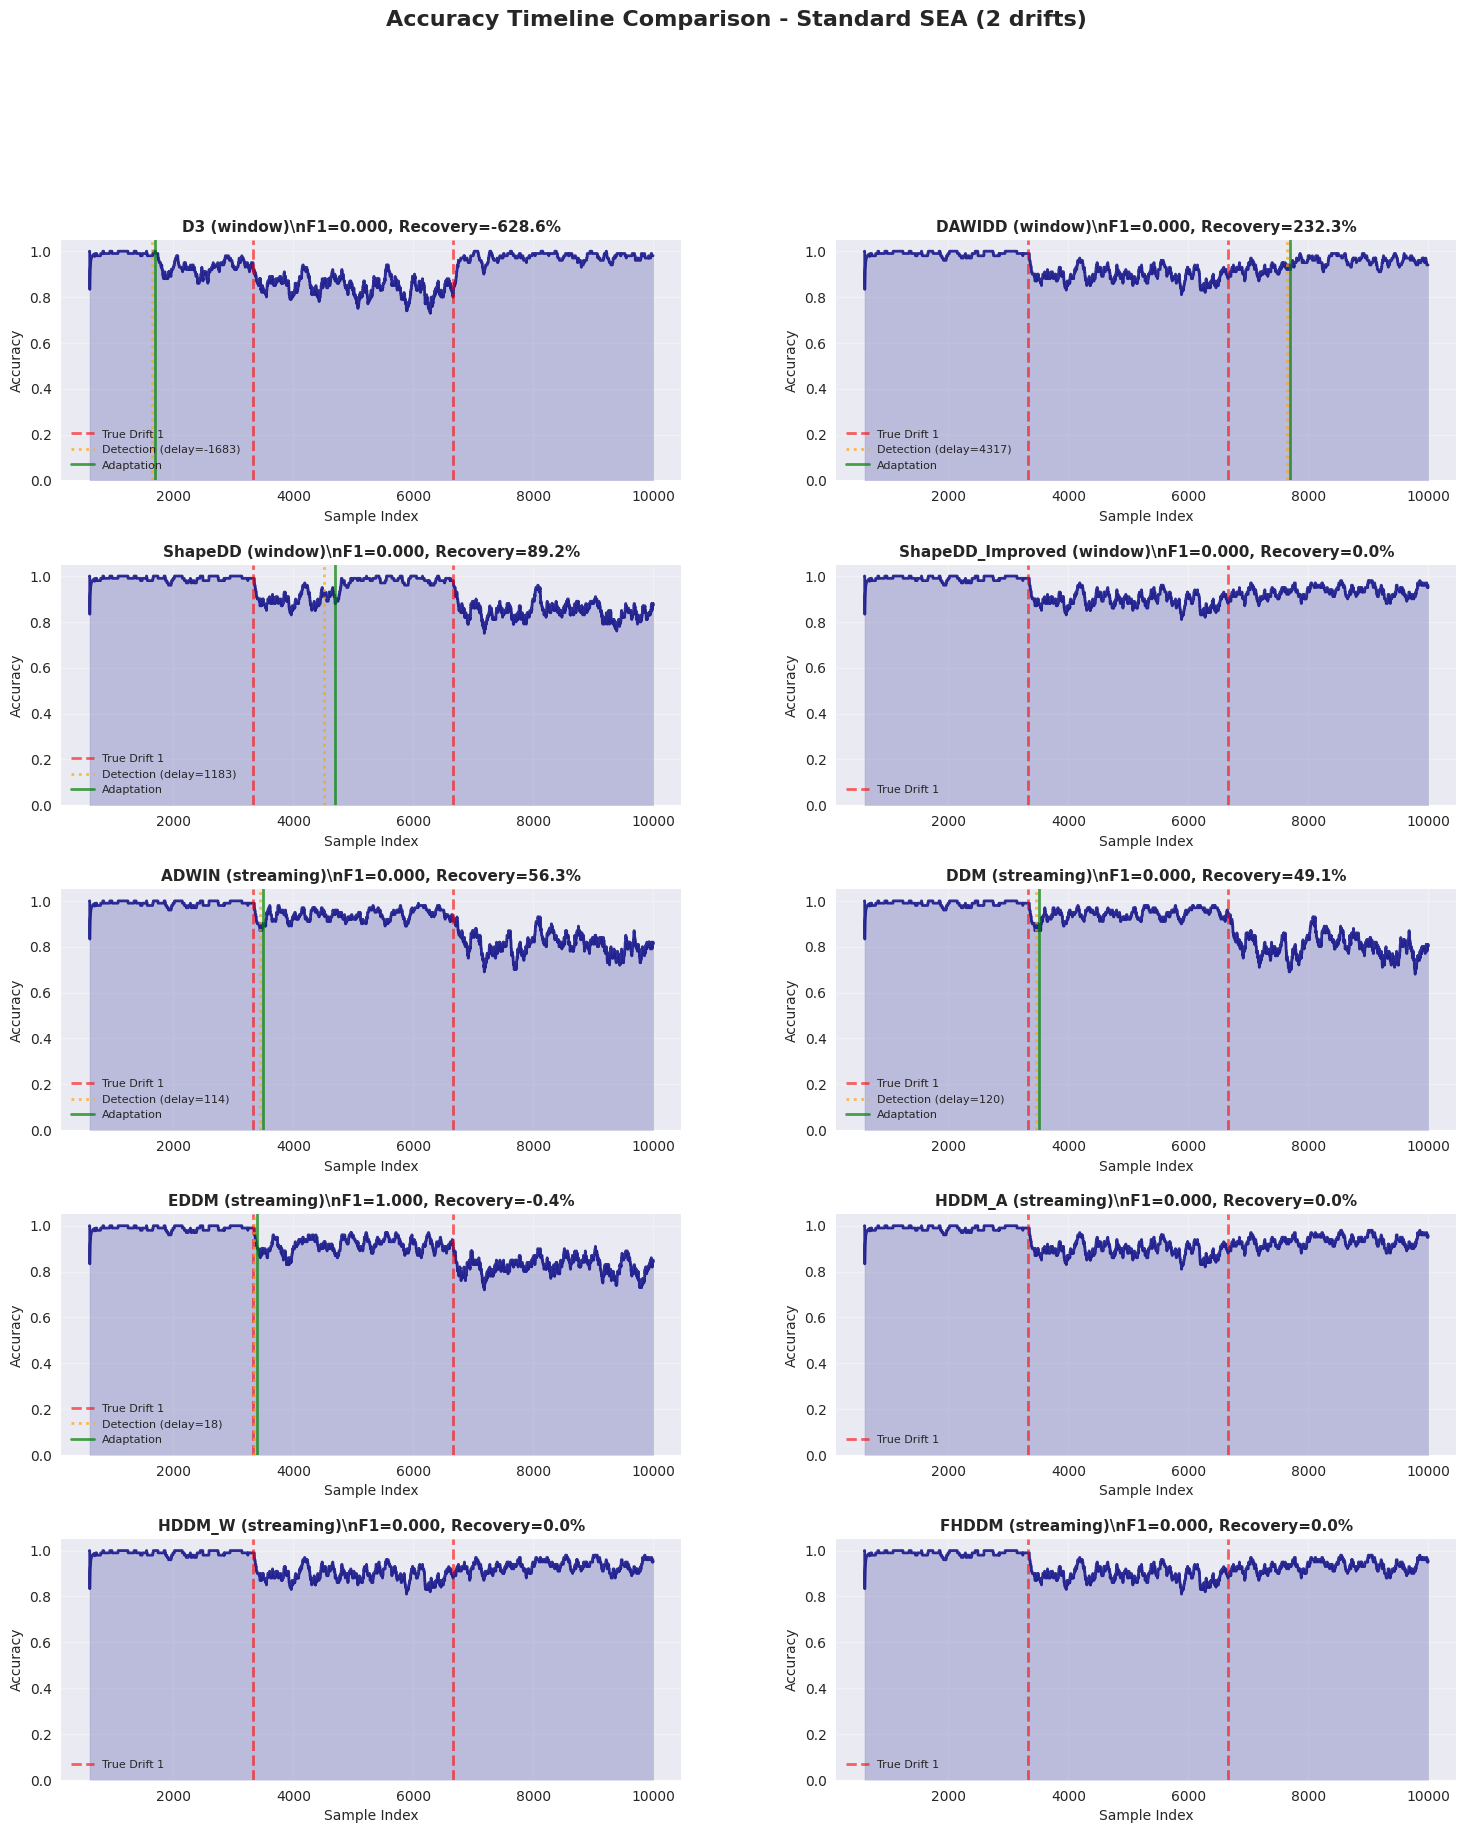


  Visualizing Enhanced SEA (2 drift events)...


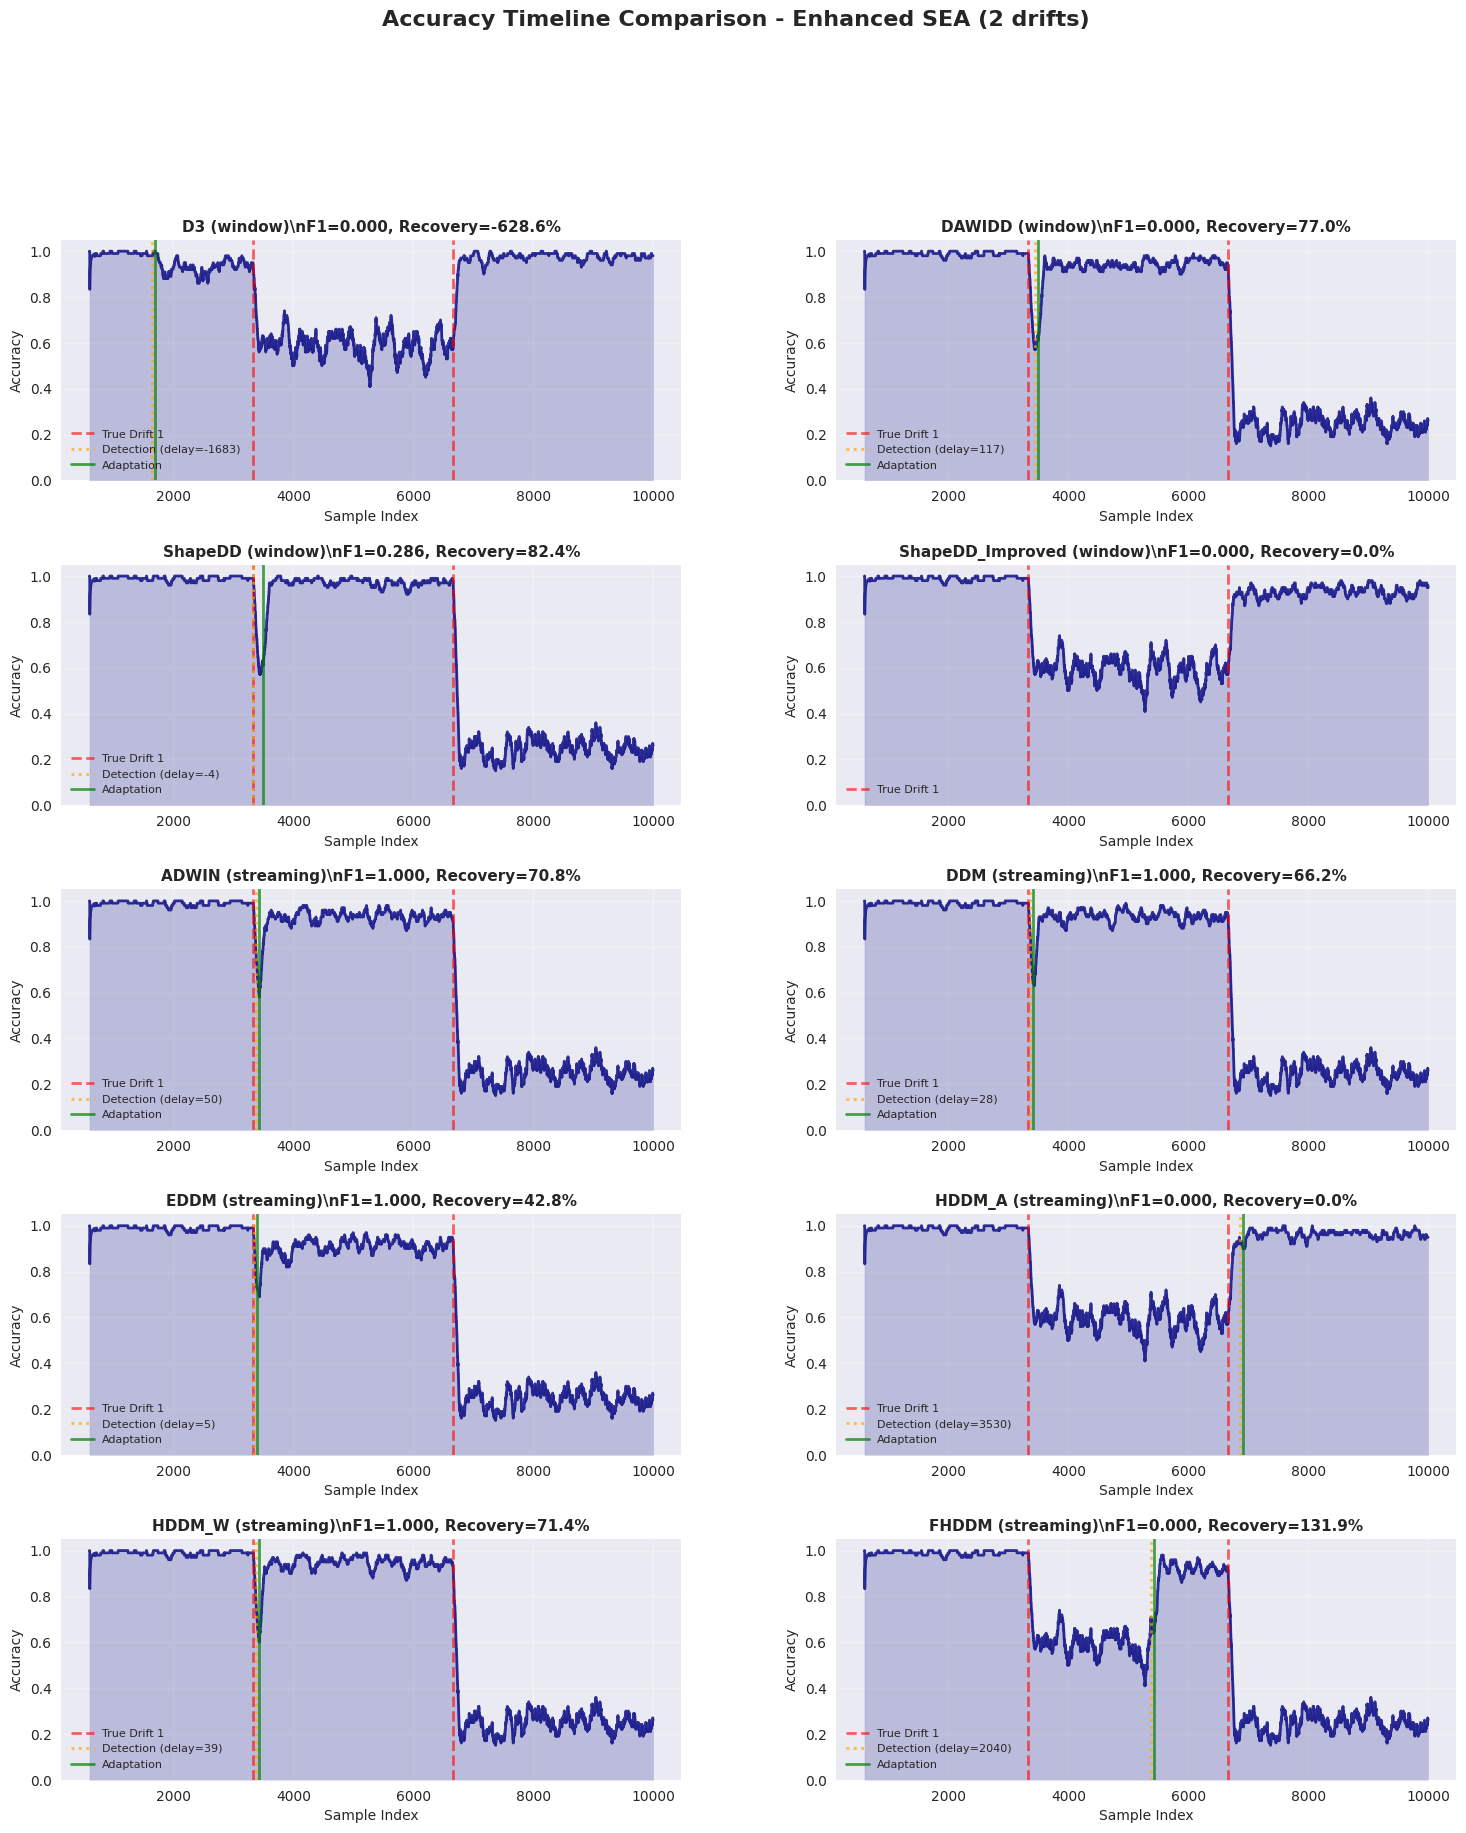


  Visualizing STAGGER (1 drift events)...


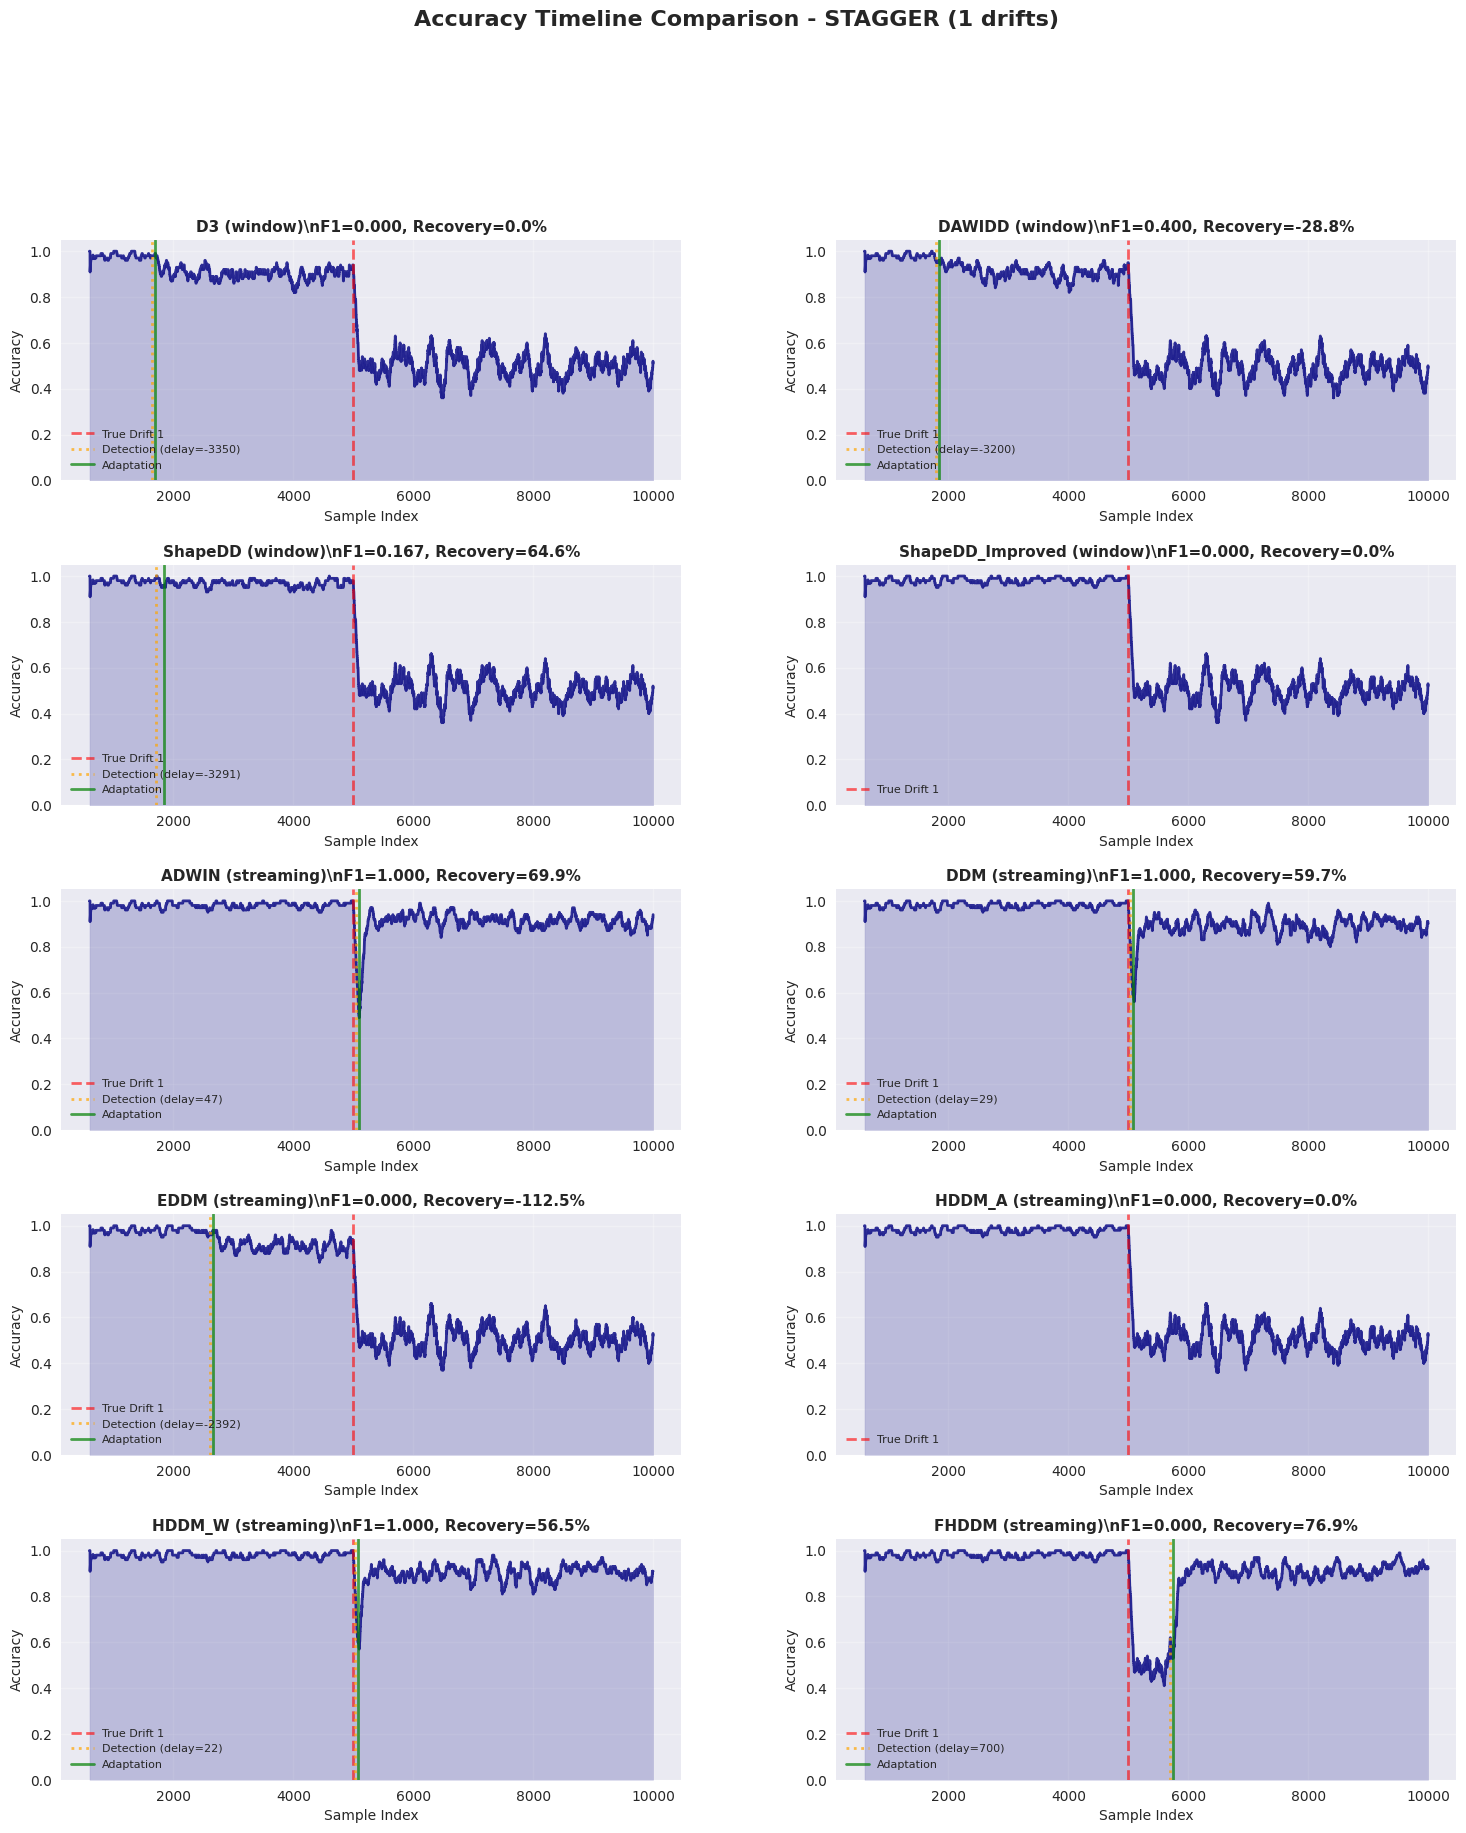


  Visualizing Hyperplane (2 drift events)...


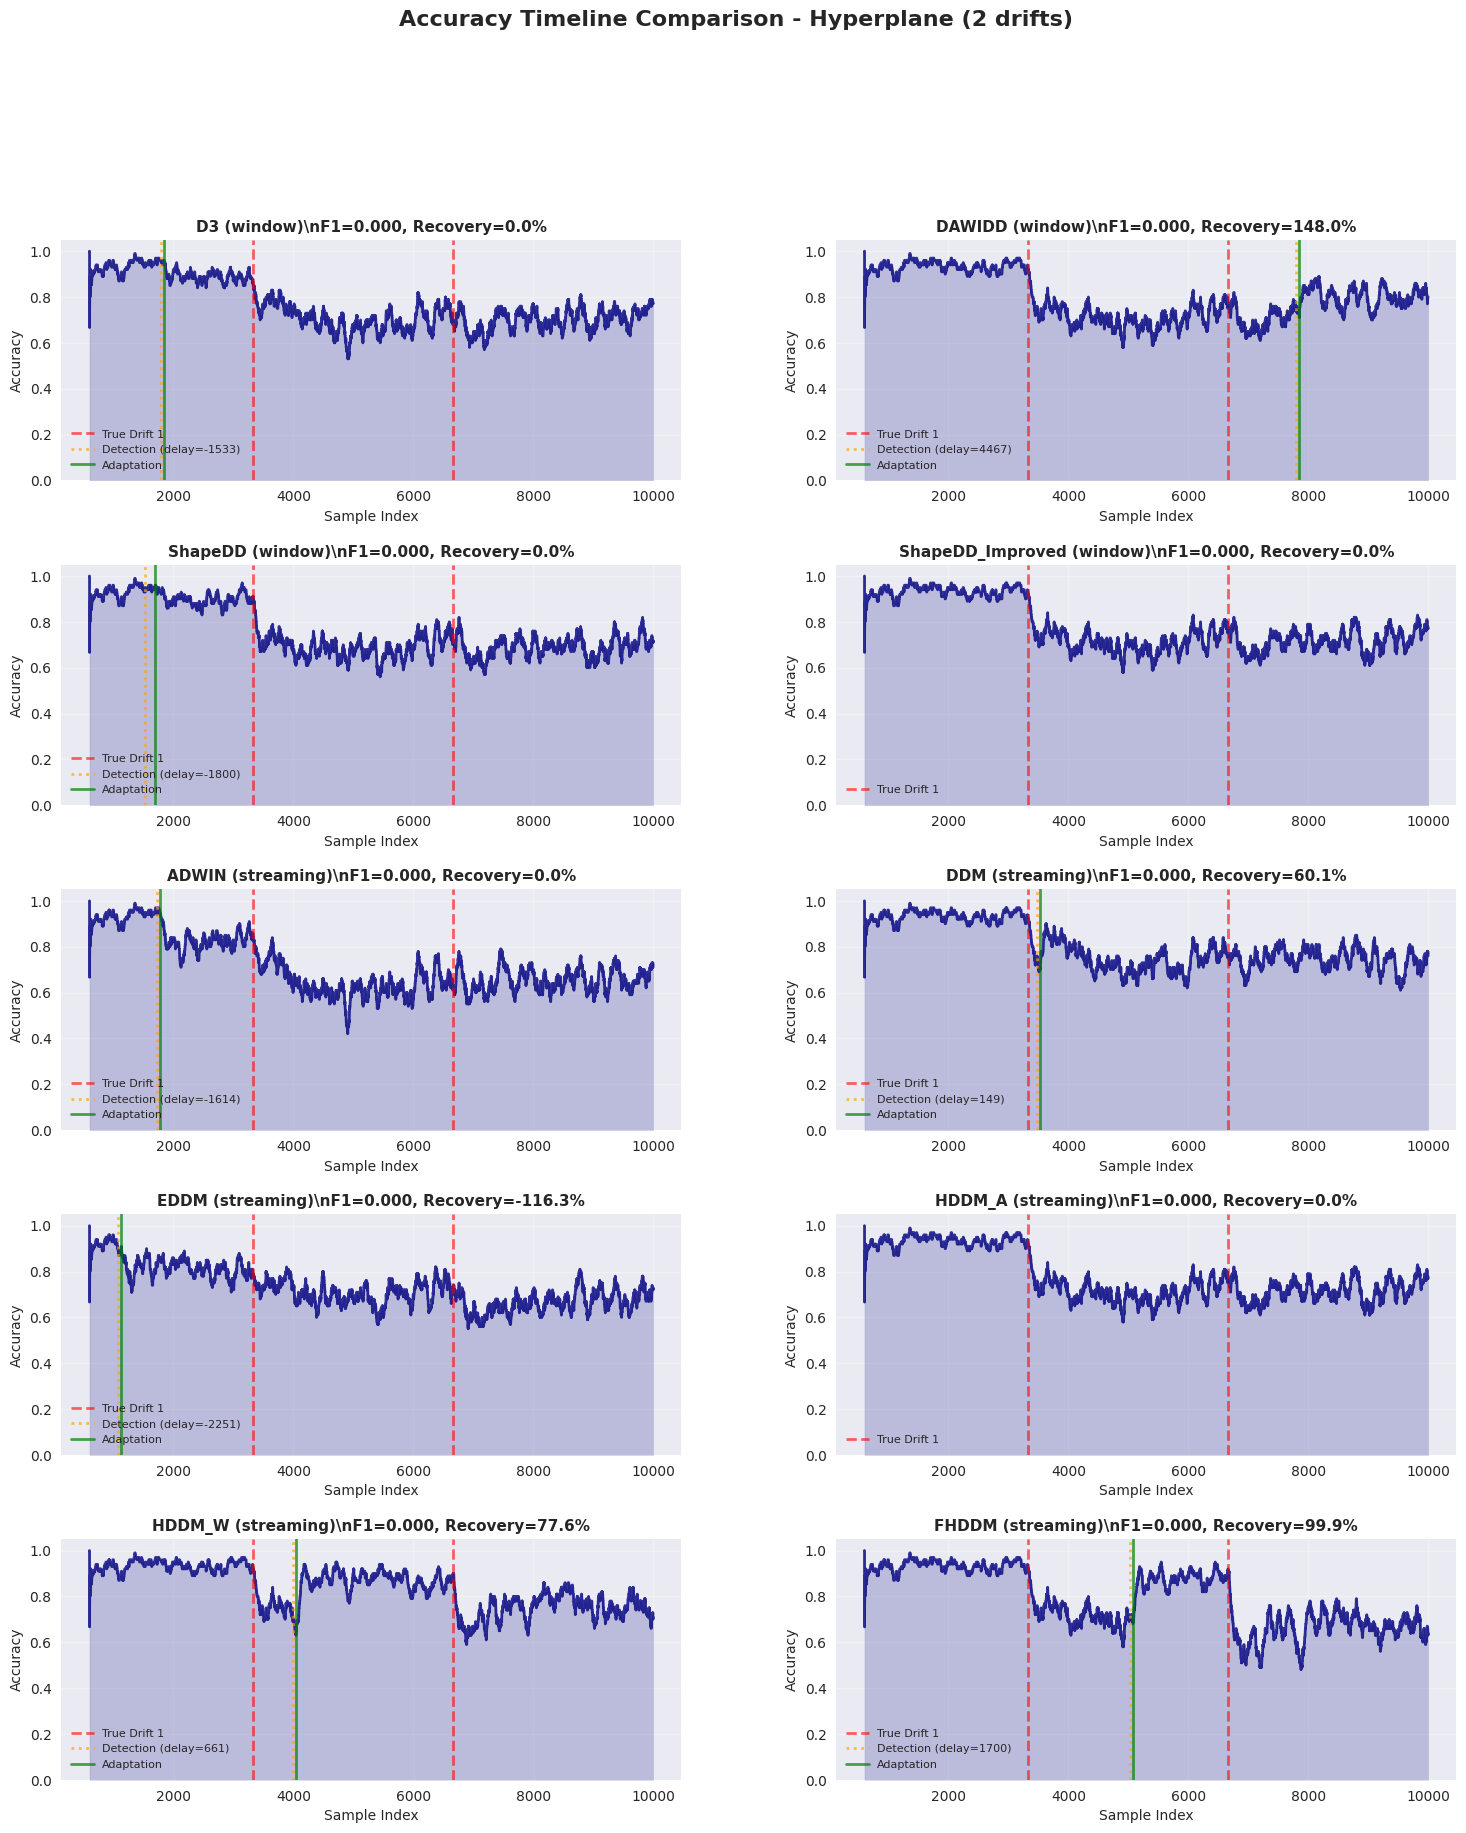


  Visualizing gen_random (3 drift events)...


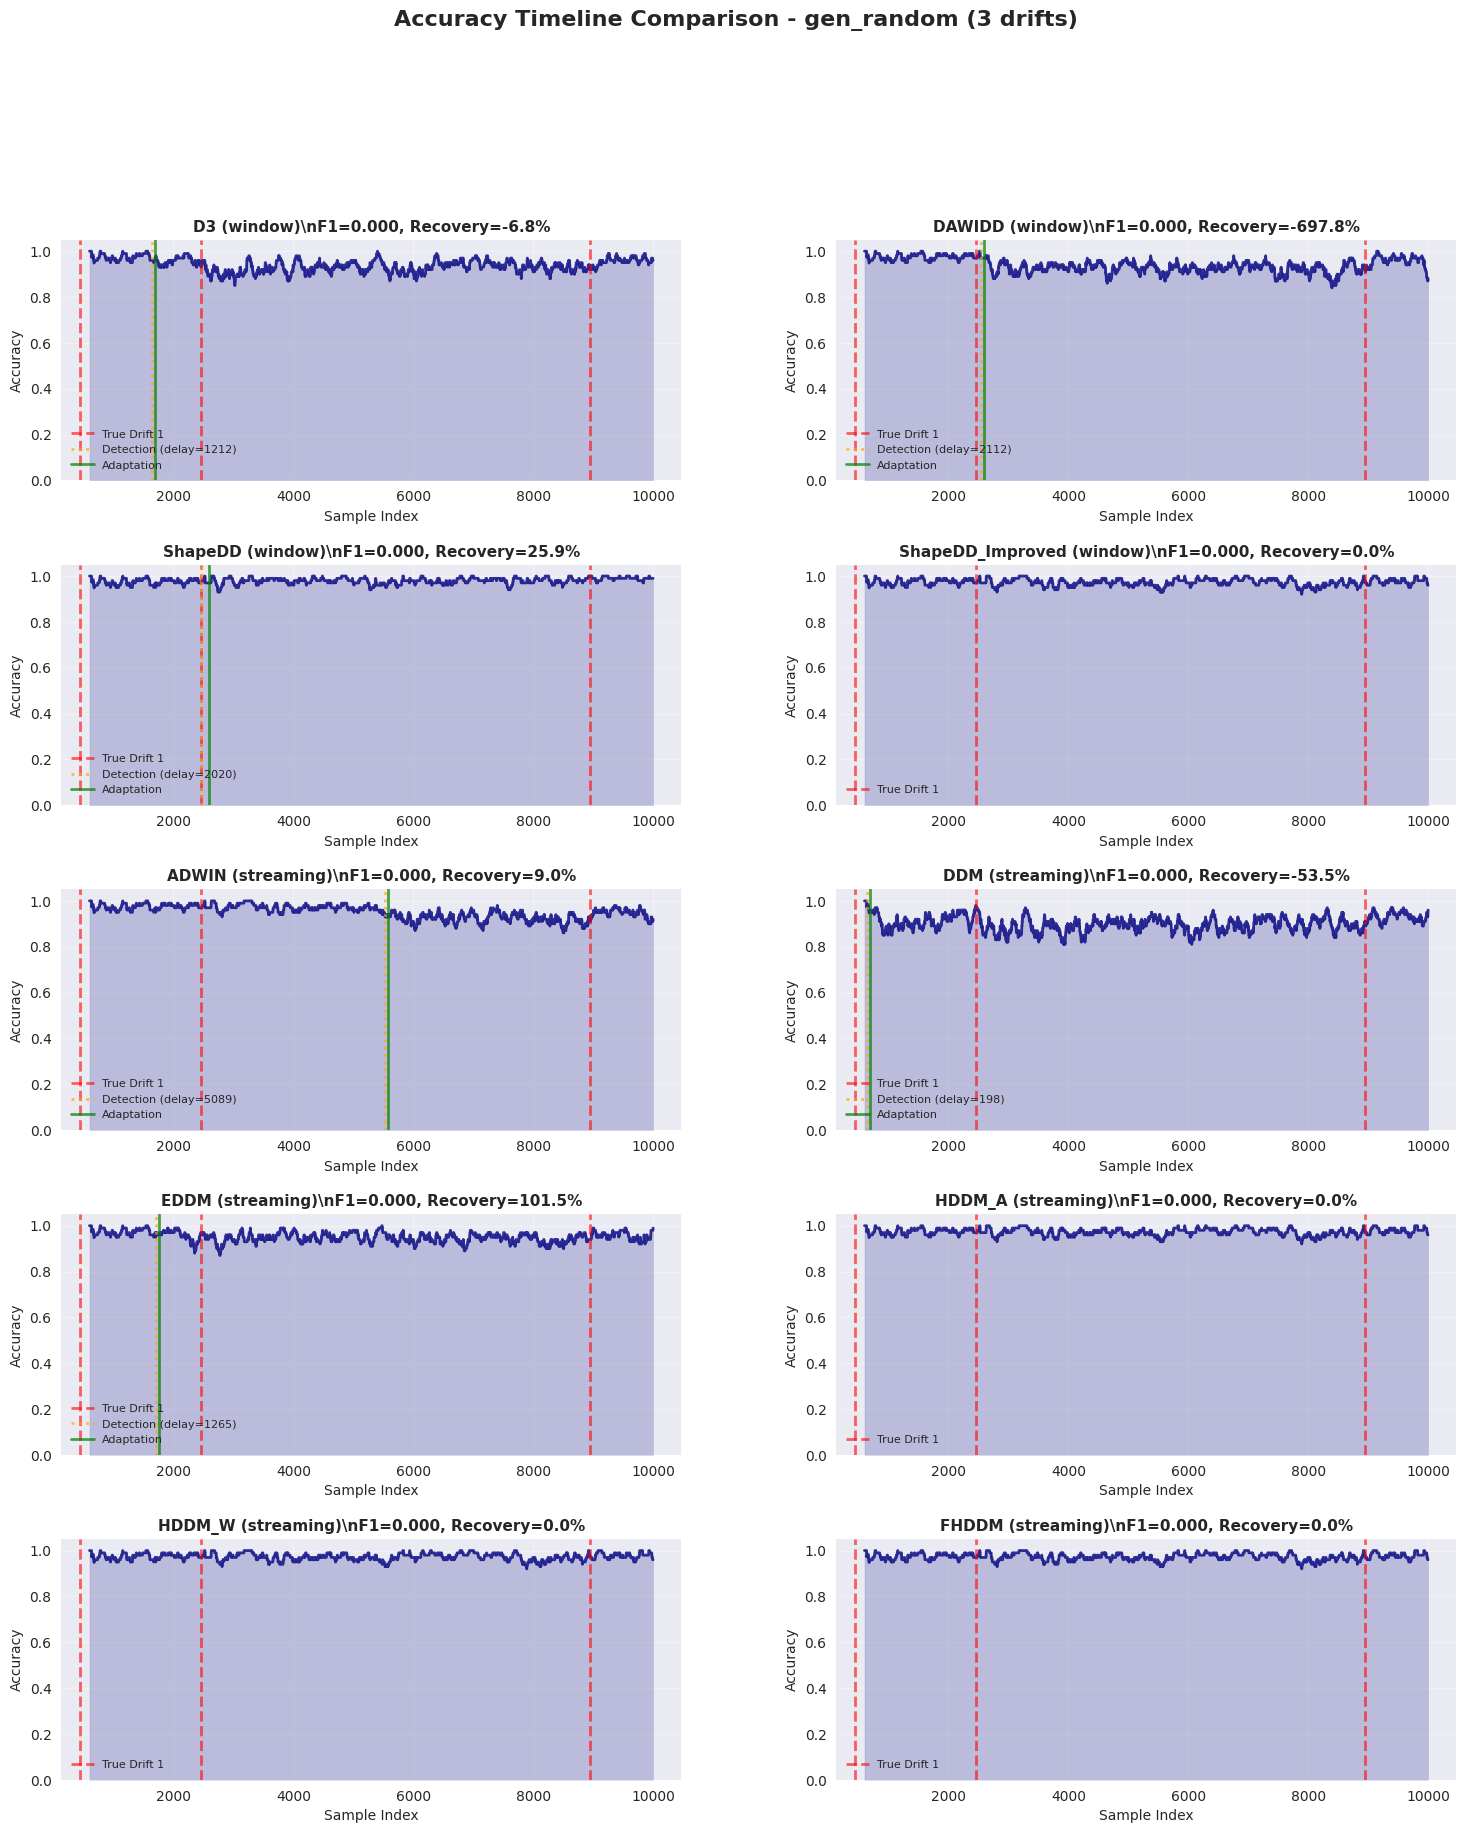


✓ Per-dataset timeline visualizations complete (5 datasets)


In [9]:
# ============================================================================
# SECTION 9: VISUALIZATION - PER-DATASET ACCURACY TIMELINE (ALL DATASETS)
# ============================================================================

if len(comprehensive_df) == 0 or len(all_comprehensive_results) == 0:
    print("⚠ No results to visualize - run experiments first")
else:
    # Create visualizations for EACH dataset separately
    unique_datasets = comprehensive_df['Dataset'].unique()
    
    print(f"Generating timeline visualizations for {len(unique_datasets)} datasets...")
    
    for dataset_name in unique_datasets:
        dataset_data = [r for r in all_comprehensive_results if r['dataset'] == dataset_name]
        
        if len(dataset_data) == 0:
            continue
        
        # Get dataset info
        first_result = dataset_data[0]
        dataset_display_name = first_result['dataset_name']
        true_drift_point = first_result.get('true_drift_point', DRIFT_POSITION)
        all_drift_positions = first_result.get('all_drift_positions', [true_drift_point])
        n_drift_events = first_result.get('n_drift_events', 1)
        
        print(f"\n  Visualizing {dataset_display_name} ({n_drift_events} drift events)...")
        
        n_detectors = len(dataset_data)
        n_cols = 2
        n_rows = (n_detectors + 1) // 2
        
        fig = plt.figure(figsize=(18, 4 * n_rows))
        gs = fig.add_gridspec(n_rows, n_cols, hspace=0.35, wspace=0.25)
        fig.suptitle(f'Accuracy Timeline Comparison - {dataset_display_name} ({n_drift_events} drifts)', 
                    fontsize=16, fontweight='bold', y=0.995)
        
        for idx, result in enumerate(dataset_data):
            row = idx // n_cols
            col = idx % n_cols
            ax = fig.add_subplot(gs[row, col])
            
            # Extract accuracy timeline
            acc_timeline = result.get('accuracy_timeline', [])
            if len(acc_timeline) > 0:
                # Handle both 'acc' and 'accuracy' keys for compatibility
                acc_indices = np.array([item['idx'] for item in acc_timeline])
                acc_values = np.array([item.get('acc', item.get('accuracy', 0)) for item in acc_timeline])
                
                # Plot accuracy
                ax.plot(acc_indices, acc_values, linewidth=2, color='navy', alpha=0.8)
                ax.fill_between(acc_indices, 0, acc_values, alpha=0.2, color='navy')
                
                # Mark ALL true drift positions
                for drift_idx, true_drift in enumerate(all_drift_positions):
                    ax.axvline(true_drift, color='red', linestyle='--', linewidth=2, 
                              label=f'True Drift {drift_idx+1}' if drift_idx == 0 else '', 
                              alpha=0.6)
                
                if result.get('drift_detected', False):
                    detection_idx = result['detections'][0] if len(result.get('detections', [])) > 0 else None
                    if detection_idx:
                        ax.axvline(detection_idx, color='orange', linestyle=':', linewidth=2,
                                  label=f'Detection (delay={detection_idx - true_drift_point})', alpha=0.7)
                    
                    if result.get('adaptation_idx'):
                        ax.axvline(result['adaptation_idx'], color='green', linestyle='-', linewidth=2,
                                  label='Adaptation', alpha=0.7)
                
                # Annotations
                method_name = result['method']
                paradigm = result['paradigm']
                f1 = result.get('f1_score', 0)
                recovery = result.get('recovery_rate', 0)
                
                title = f"{method_name} ({paradigm})\\nF1={f1:.3f}, Recovery={recovery:.1f}%"
                ax.set_title(title, fontsize=11, fontweight='bold')
                ax.set_xlabel('Sample Index', fontsize=10)
                ax.set_ylabel('Accuracy', fontsize=10)
                ax.set_ylim([0, 1.05])
                ax.legend(loc='lower left', fontsize=8)
                ax.grid(alpha=0.3)
            else:
                ax.text(0.5, 0.5, f'{result["method"]}\\nNo timeline data',
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(result['method'], fontsize=11)
        
        plt.tight_layout()
        plt.show()
    
    print(f"\n✓ Per-dataset timeline visualizations complete ({len(unique_datasets)} datasets)")


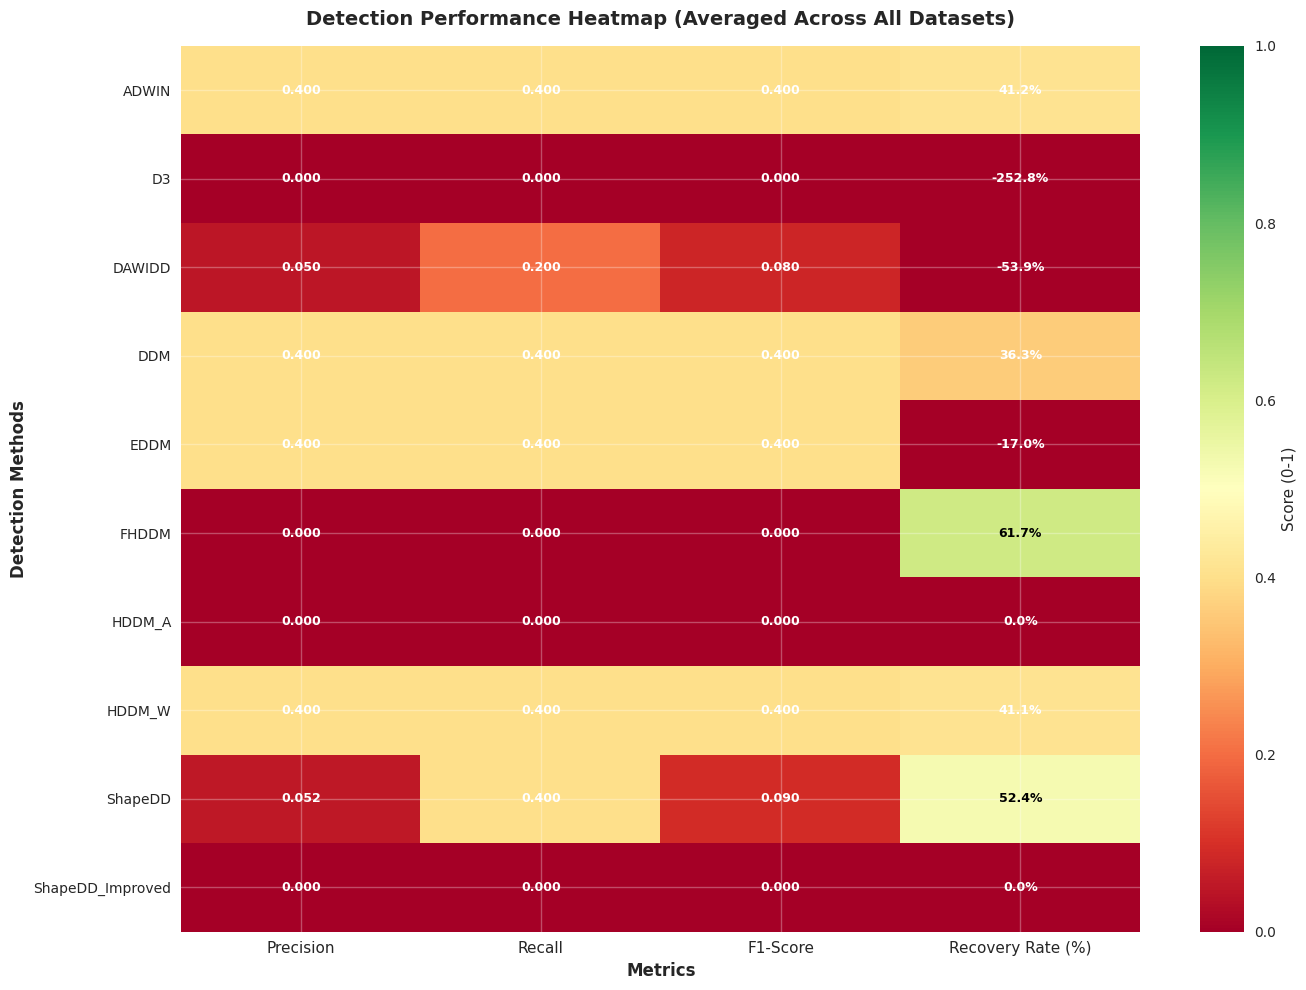

✓ Detection performance heatmap created


In [10]:
# ============================================================================
# SECTION 10: VISUALIZATION - OVERALL DETECTION PERFORMANCE HEATMAP
# ============================================================================

if len(comprehensive_df) == 0:
    print("⚠ No results to visualize - run experiments first")
else:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Prepare data
    metrics_to_plot = ['Precision', 'Recall', 'F1', 'Recovery_Rate_%']
    metric_labels = ['Precision', 'Recall', 'F1-Score', 'Recovery Rate (%)']
    
    # Group by method and take mean across datasets
    method_metrics = comprehensive_df.groupby('Method')[metrics_to_plot].mean()
    methods = method_metrics.index.tolist()
    
    if len(methods) == 0:
        print("⚠ No methods to visualize")
    else:
        # Normalize recovery rate to 0-1 scale
        data_matrix = method_metrics.values.copy()
        data_matrix[:, 3] = data_matrix[:, 3] / 100
        
        # Create heatmap
        im = ax.imshow(data_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        
        # Set ticks and labels
        ax.set_xticks(range(len(metric_labels)))
        ax.set_xticklabels(metric_labels, fontsize=11)
        ax.set_yticks(range(len(methods)))
        ax.set_yticklabels(methods, fontsize=10)
        
        # Add values as text
        for i in range(len(methods)):
            for j in range(len(metric_labels)):
                value = data_matrix[i, j]
                display_value = f'{value:.3f}' if j < 3 else f'{value*100:.1f}%'
                text_color = 'white' if value < 0.5 else 'black'
                ax.text(j, i, display_value, ha='center', va='center',
                       color=text_color, fontsize=9, fontweight='bold')
        
        # Labels and title
        ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
        ax.set_ylabel('Detection Methods', fontsize=12, fontweight='bold')
        ax.set_title('Detection Performance Heatmap (Averaged Across All Datasets)',
                    fontsize=14, fontweight='bold', pad=15)
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Score (0-1)', fontsize=11)
        
        plt.tight_layout()
        plt.show()
        
        print("✓ Detection performance heatmap created")


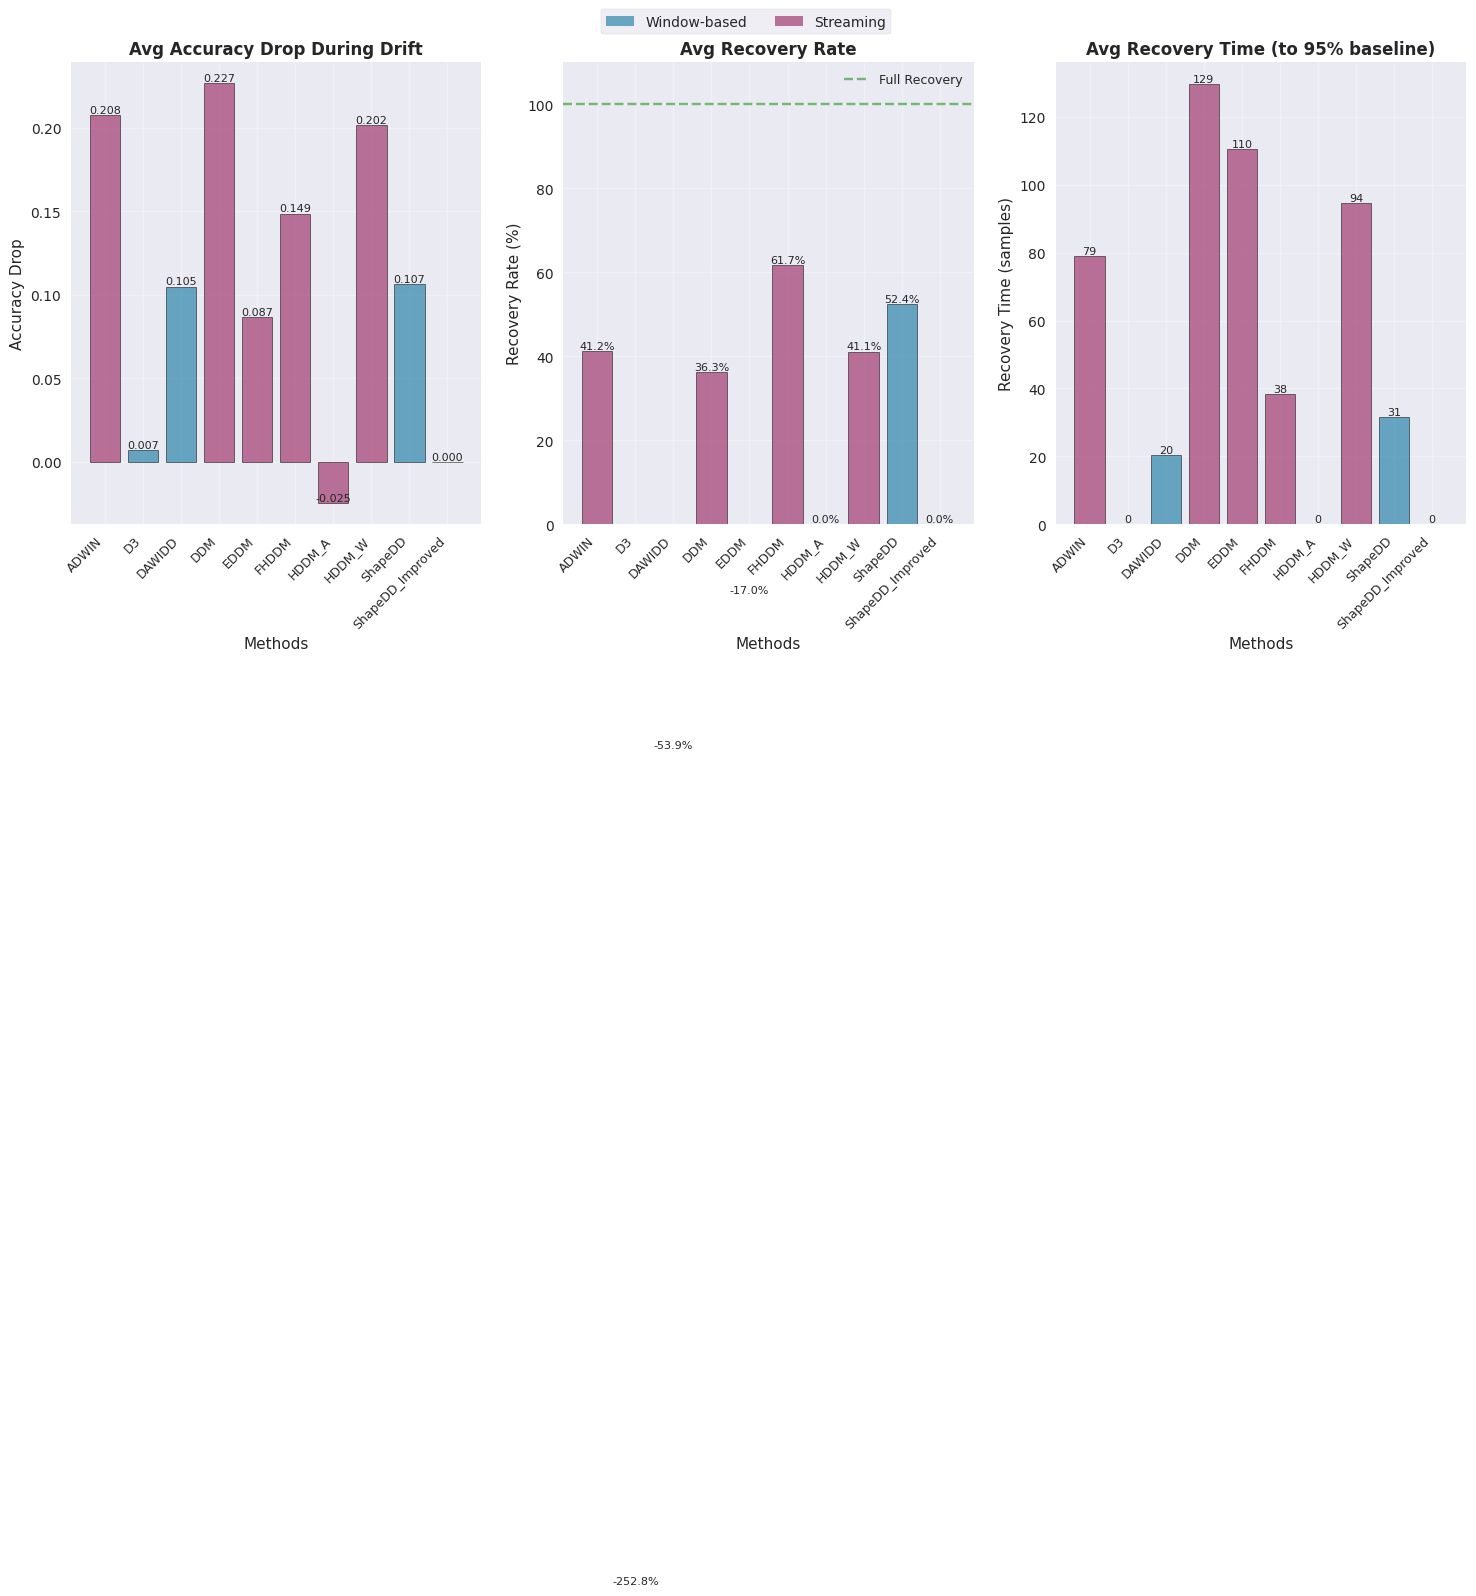

✓ Recovery analysis visualization created


In [11]:
# ============================================================================
# SECTION 11: VISUALIZATION - RECOVERY ANALYSIS
# ============================================================================

if len(comprehensive_df) == 0:
    print("⚠ No results to visualize - run experiments first")
else:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    colors_paradigm = {'window': '#2E86AB', 'streaming': '#A23B72'}
    
    # Average across datasets for each method
    method_stats = comprehensive_df.groupby(['Method', 'Paradigm']).agg({
        'Acc_Drop': 'mean',
        'Recovery_Rate_%': 'mean', 
        'Recovery_Time': 'mean'
    }).reset_index()
    
    if len(method_stats) == 0:
        print("⚠ No method statistics available")
    else:
        methods = method_stats['Method'].tolist()
        paradigms = method_stats['Paradigm'].tolist()
        bar_colors = [colors_paradigm.get(p, '#2E86AB') for p in paradigms]
        
        # Plot 1: Accuracy Drop
        ax = axes[0]
        bars = ax.bar(range(len(methods)), method_stats['Acc_Drop'], 
                     color=bar_colors, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.set_xlabel('Methods', fontsize=11)
        ax.set_ylabel('Accuracy Drop', fontsize=11)
        ax.set_title('Avg Accuracy Drop During Drift', fontsize=12, fontweight='bold')
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height):
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 2: Recovery Rate
        ax = axes[1]
        bars = ax.bar(range(len(methods)), method_stats['Recovery_Rate_%'],
                     color=bar_colors, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.set_xlabel('Methods', fontsize=11)
        ax.set_ylabel('Recovery Rate (%)', fontsize=11)
        ax.set_title('Avg Recovery Rate', fontsize=12, fontweight='bold')
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=9)
        ax.axhline(100, color='green', linestyle='--', alpha=0.5, label='Full Recovery')
        ax.set_ylim([0, 110])
        ax.legend(fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height):
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
        
        # Plot 3: Recovery Time
        ax = axes[2]
        bars = ax.bar(range(len(methods)), method_stats['Recovery_Time'],
                     color=bar_colors, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.set_xlabel('Methods', fontsize=11)
        ax.set_ylabel('Recovery Time (samples)', fontsize=11)
        ax.set_title('Avg Recovery Time (to 95% baseline)', fontsize=12, fontweight='bold')
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height):
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom', fontsize=8)
        
        # Legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=colors_paradigm['window'], label='Window-based', alpha=0.7),
            Patch(facecolor=colors_paradigm['streaming'], label='Streaming', alpha=0.7)
        ]
        fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98),
                  ncol=2, fontsize=10, frameon=True)
        
        plt.tight_layout()
        plt.show()
        
        print("✓ Recovery analysis visualization created")


Generating detection timelines for 5 datasets...

  Visualizing Standard SEA (2 drift events)...


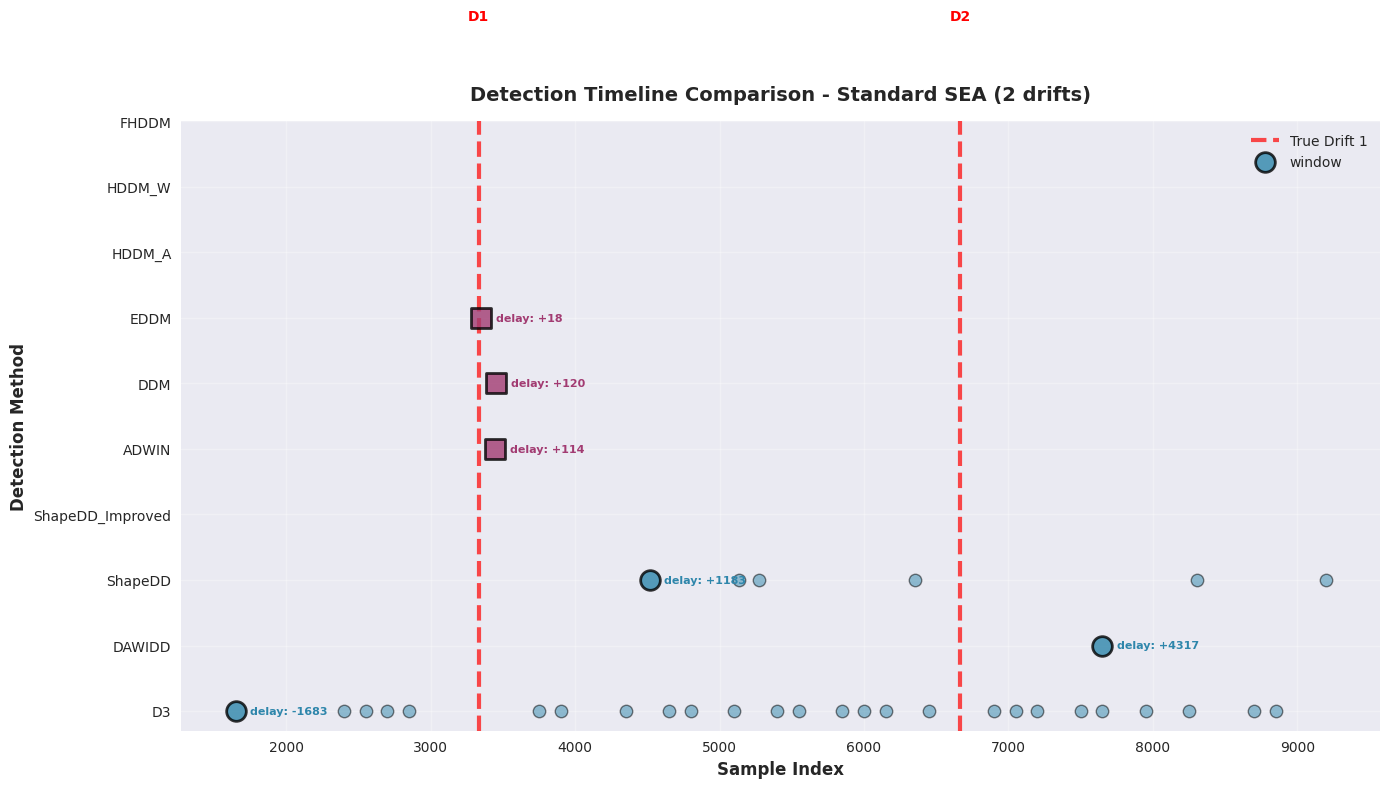


  Visualizing Enhanced SEA (2 drift events)...


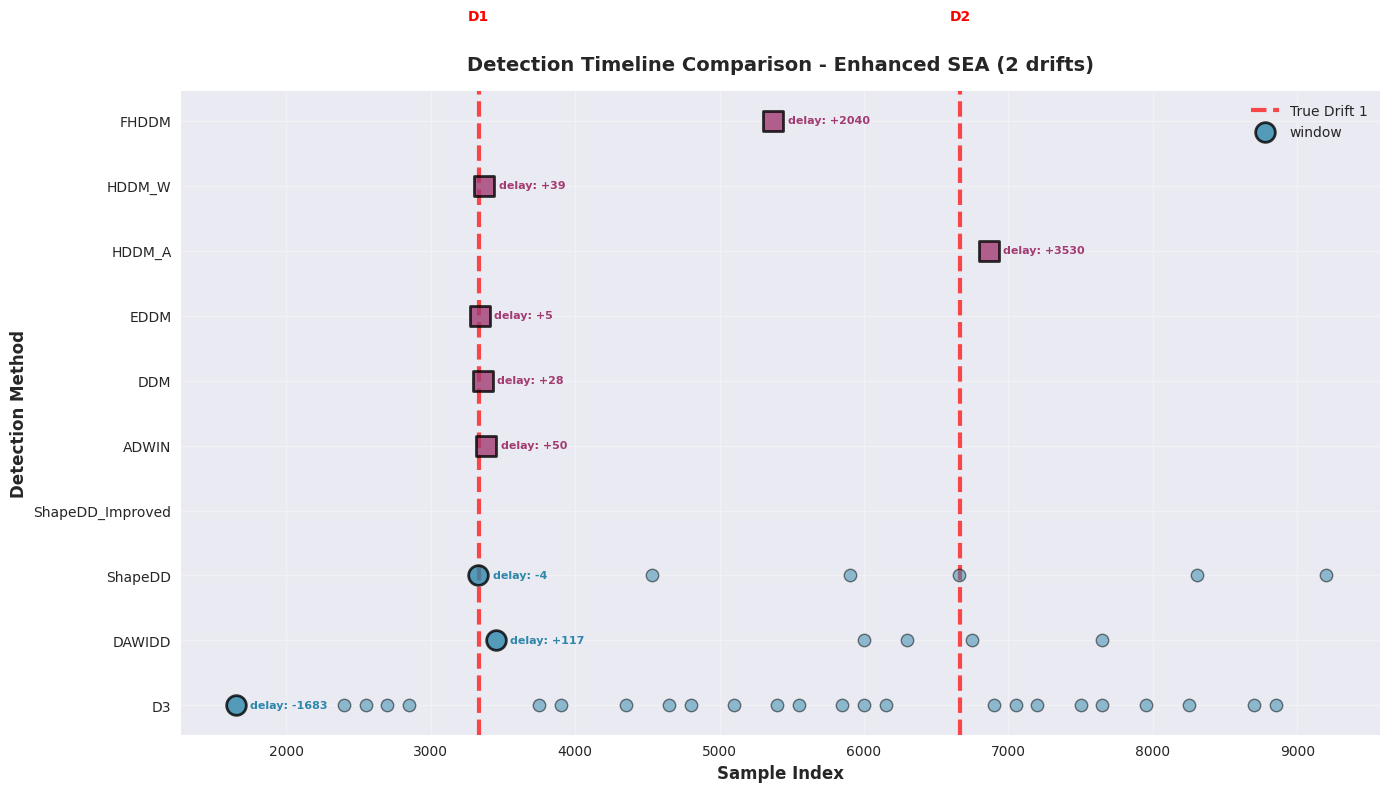


  Visualizing STAGGER (1 drift events)...


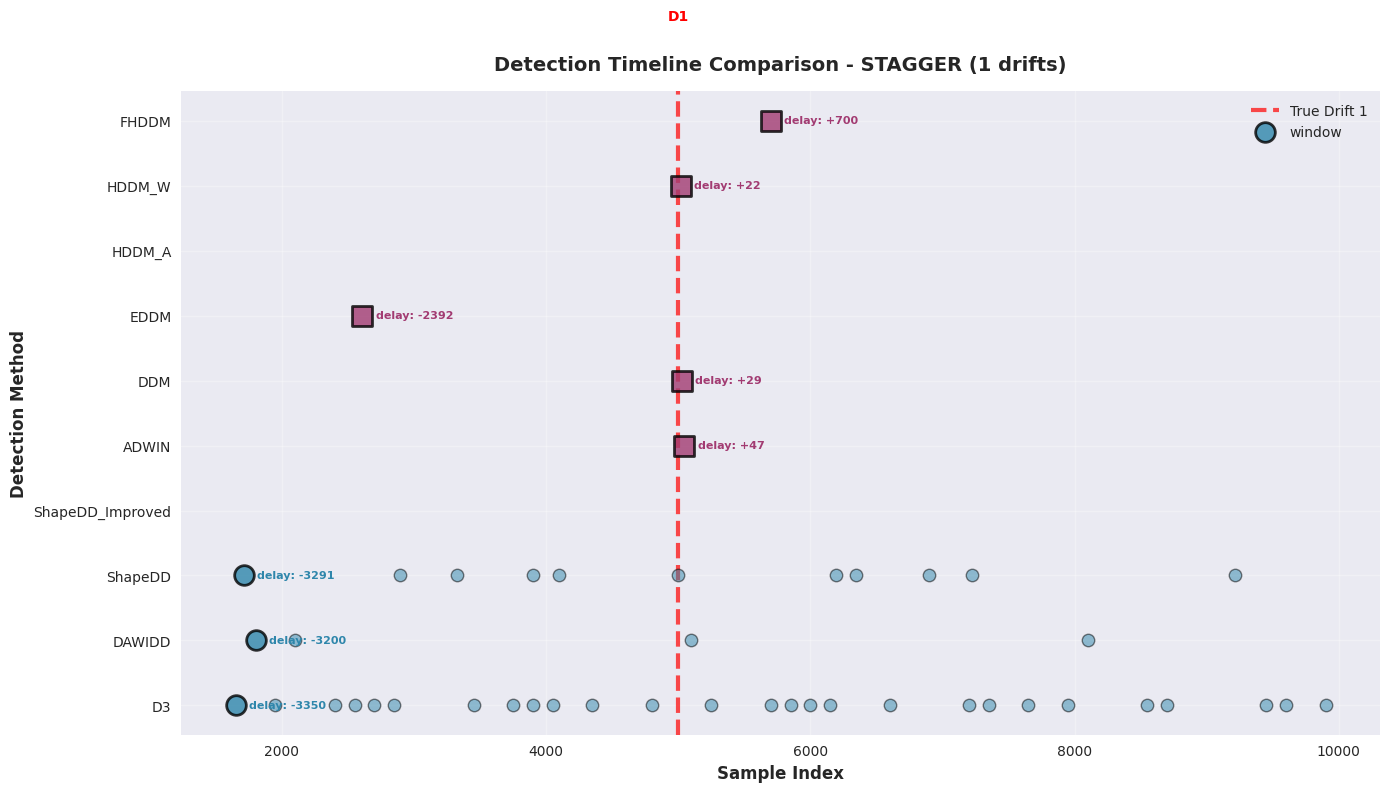


  Visualizing Hyperplane (2 drift events)...


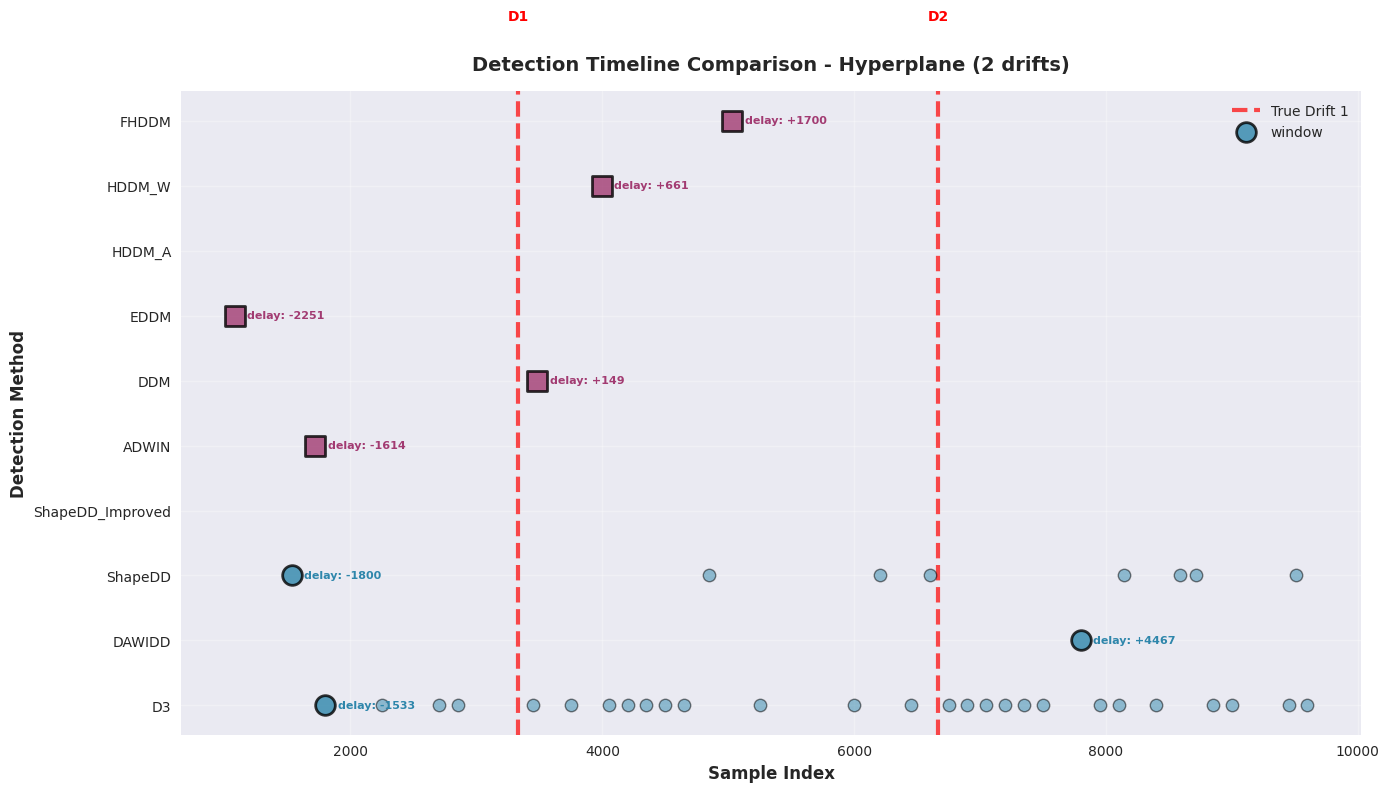


  Visualizing gen_random (3 drift events)...


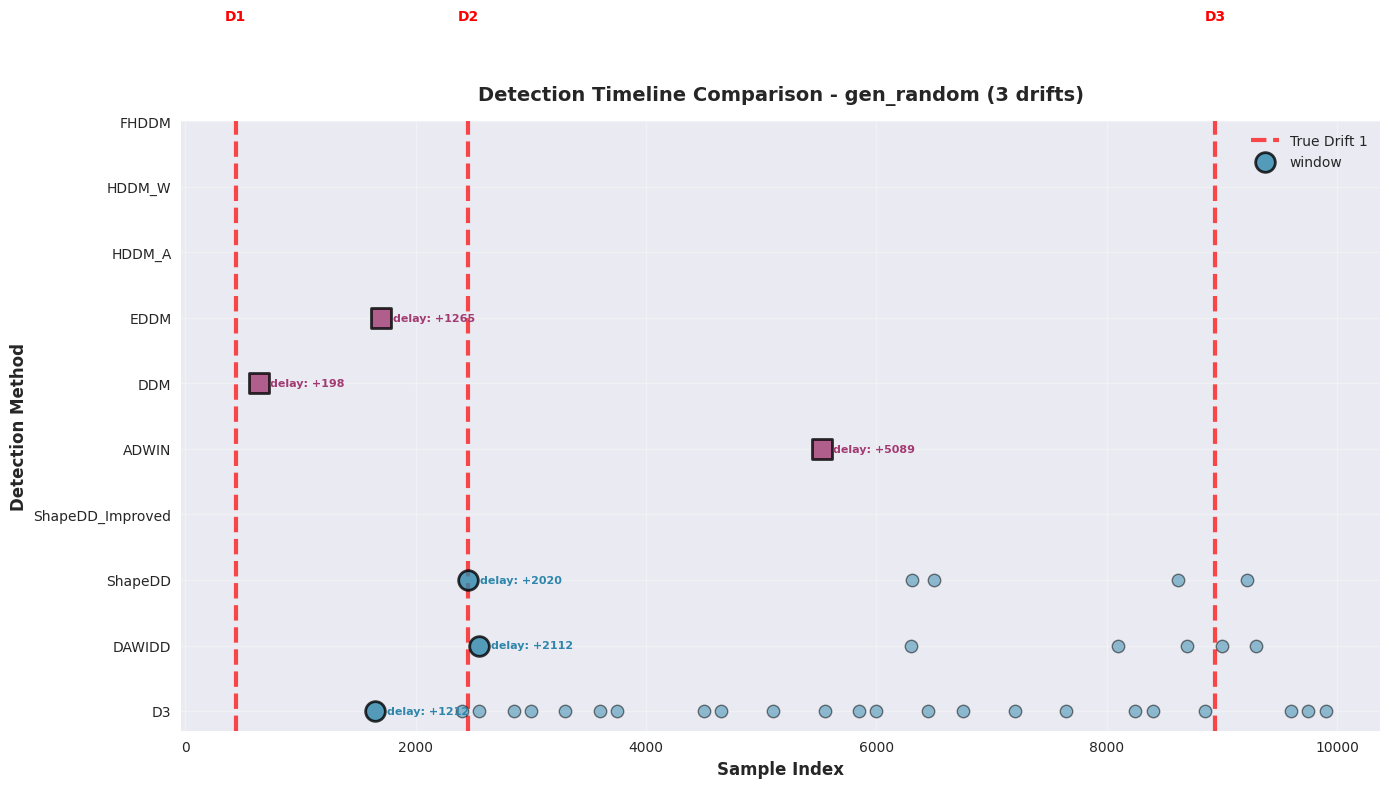


✓ Detection timeline comparisons complete (5 datasets)


In [12]:
# ============================================================================
# SECTION 12: VISUALIZATION - DETECTION TIMELINE COMPARISON (ALL DATASETS)
# ============================================================================

if len(comprehensive_df) == 0 or len(all_comprehensive_results) == 0:
    print("⚠ No results to visualize - run experiments first")
else:
    # Show detection timelines for ALL datasets
    unique_datasets = comprehensive_df['Dataset'].unique()
    
    print(f"Generating detection timelines for {len(unique_datasets)} datasets...")
    
    for dataset_name in unique_datasets:
        dataset_results = [r for r in all_comprehensive_results if r['dataset'] == dataset_name]
        
        if len(dataset_results) == 0:
            continue
        
        first_result = dataset_results[0]
        true_drift_point = first_result.get('true_drift_point', DRIFT_POSITION)
        all_drift_positions = first_result.get('all_drift_positions', [true_drift_point])
        dataset_display_name = first_result['dataset_name']
        n_drift_events = first_result.get('n_drift_events', 1)
        
        print(f"\n  Visualizing {dataset_display_name} ({n_drift_events} drift events)...")
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Plot ALL true drift positions as vertical lines
        for drift_idx, drift_pos in enumerate(all_drift_positions):
            label = f'True Drift {drift_idx+1}' if drift_idx == 0 else ''
            ax.axvline(drift_pos, color='red', linestyle='--', linewidth=3, 
                      label=label if drift_idx == 0 else '', alpha=0.7, zorder=1)
            # Add drift number annotation
            ax.text(drift_pos, len(dataset_results) + 0.5, f'D{drift_idx+1}', 
                   ha='center', va='bottom', fontsize=10, fontweight='bold', color='red')
        
        # Plot detections for each method
        colors_paradigm = {'window': '#2E86AB', 'streaming': '#A23B72'}
        method_names = []
        y_positions = []
        
        for idx, result in enumerate(dataset_results):
            method_name = f"{result['method']}"
            method_names.append(method_name)
            y_positions.append(idx)
            
            detections = result.get('detections', [])
            paradigm = result.get('paradigm', 'window')
            color = colors_paradigm.get(paradigm, '#2E86AB')
            marker = 'o' if paradigm == 'window' else 's'
            
            if len(detections) > 0:
                # Plot first detection (triggers adaptation)
                ax.scatter(detections[0], idx, c=color, s=200, marker=marker, 
                          edgecolors='black', linewidth=2, alpha=0.8, zorder=3,
                          label=paradigm if idx < 2 else '')
                
                # Plot additional detections (smaller)
                if len(detections) > 1:
                    ax.scatter(detections[1:], [idx]*len(detections[1:]), c=color, s=80, 
                              marker=marker, edgecolors='black', linewidth=1, alpha=0.5, zorder=2)
                
                # Calculate delay relative to PRIMARY drift (first drift)
                delay = detections[0] - true_drift_point
                delay_text = f"delay: {delay:+d}"
                ax.text(detections[0] + 100, idx, delay_text, fontsize=8, 
                       va='center', color=color, fontweight='bold')
        
        ax.set_yticks(y_positions)
        ax.set_yticklabels(method_names, fontsize=10)
        ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
        ax.set_ylabel('Detection Method', fontsize=12, fontweight='bold')
        ax.set_title(f'Detection Timeline Comparison - {dataset_display_name} ({n_drift_events} drifts)', 
                    fontsize=14, fontweight='bold', pad=15)
        ax.grid(alpha=0.3, axis='x')
        
        # Legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    print(f"\n✓ Detection timeline comparisons complete ({len(unique_datasets)} datasets)")


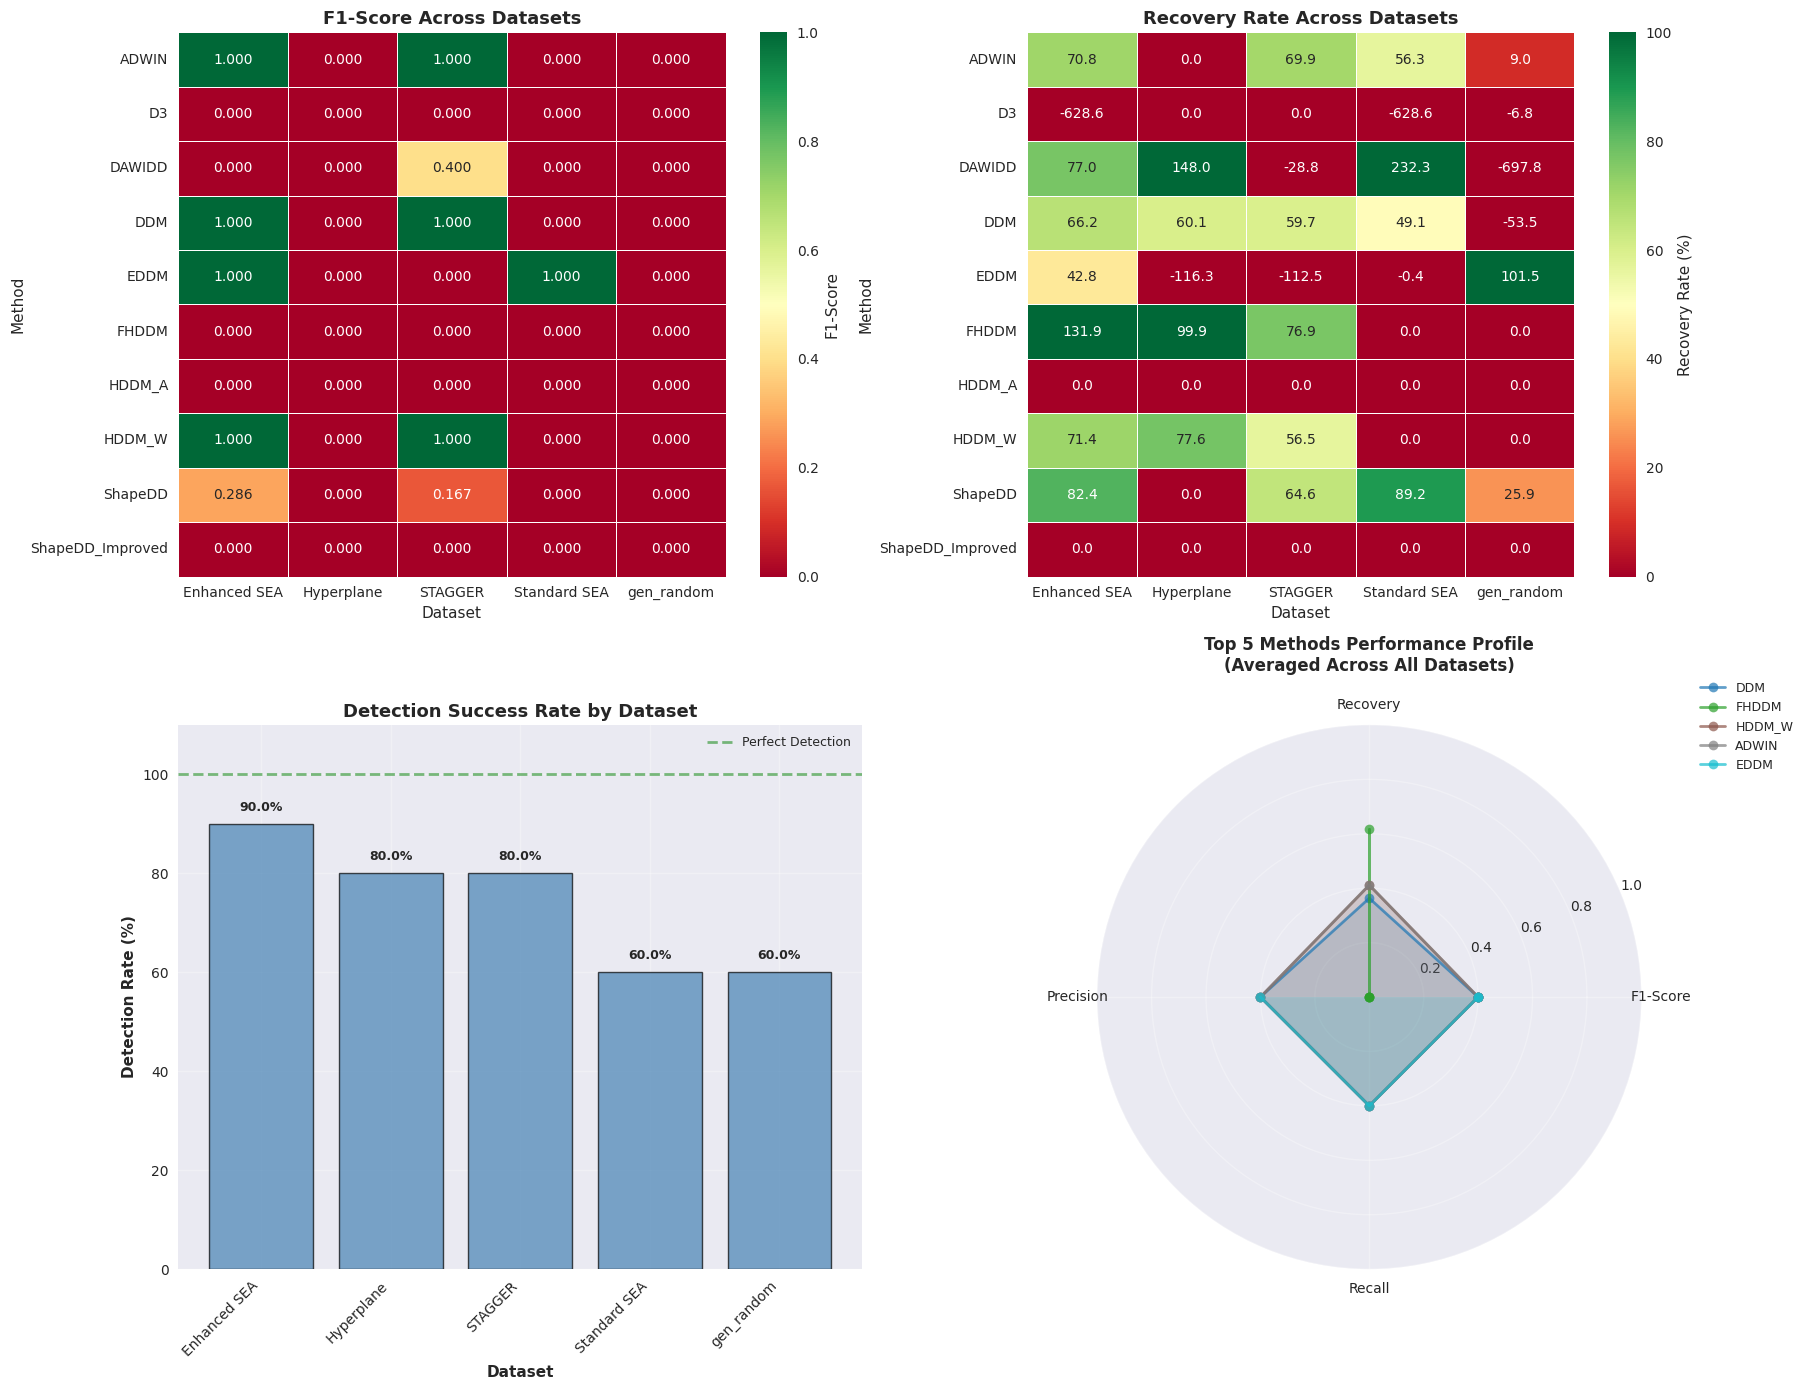

✓ Cross-dataset performance heatmap created


In [13]:
# ============================================================================
# NEW VISUALIZATION: CROSS-DATASET PERFORMANCE HEATMAP
# ============================================================================

if len(comprehensive_df) == 0:
    print("⚠ No results to visualize - run experiments first")
else:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Pivot data for heatmaps
    datasets = comprehensive_df['Dataset_Name'].unique()
    methods = comprehensive_df['Method'].unique()
    
    # Plot 1: F1-Score Heatmap
    ax = axes[0, 0]
    f1_pivot = comprehensive_df.pivot_table(values='F1', index='Method', columns='Dataset_Name', aggfunc='mean')
    sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1, 
               cbar_kws={'label': 'F1-Score'}, ax=ax, linewidths=0.5)
    ax.set_title('F1-Score Across Datasets', fontsize=13, fontweight='bold')
    ax.set_xlabel('Dataset', fontsize=11)
    ax.set_ylabel('Method', fontsize=11)
    
    # Plot 2: Recovery Rate Heatmap
    ax = axes[0, 1]
    recovery_pivot = comprehensive_df.pivot_table(values='Recovery_Rate_%', index='Method', 
                                                 columns='Dataset_Name', aggfunc='mean')
    sns.heatmap(recovery_pivot, annot=True, fmt='.1f', cmap='RdYlGn', vmin=0, vmax=100,
               cbar_kws={'label': 'Recovery Rate (%)'}, ax=ax, linewidths=0.5)
    ax.set_title('Recovery Rate Across Datasets', fontsize=13, fontweight='bold')
    ax.set_xlabel('Dataset', fontsize=11)
    ax.set_ylabel('Method', fontsize=11)
    
    # Plot 3: Detection Rate by Dataset (Bar plot)
    ax = axes[1, 0]
    detection_by_dataset = comprehensive_df.groupby('Dataset_Name')['Detected'].agg(['sum', 'count'])
    detection_by_dataset['rate'] = detection_by_dataset['sum'] / detection_by_dataset['count'] * 100
    
    bars = ax.bar(range(len(detection_by_dataset)), detection_by_dataset['rate'], 
                 color='steelblue', alpha=0.7, edgecolor='black', linewidth=1)
    ax.set_xlabel('Dataset', fontsize=11, fontweight='bold')
    ax.set_ylabel('Detection Rate (%)', fontsize=11, fontweight='bold')
    ax.set_title('Detection Success Rate by Dataset', fontsize=13, fontweight='bold')
    ax.set_xticks(range(len(detection_by_dataset)))
    ax.set_xticklabels(detection_by_dataset.index, rotation=45, ha='right')
    ax.axhline(100, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Perfect Detection')
    ax.set_ylim(0, 110)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, detection_by_dataset['rate'])):
        ax.text(i, val + 2, f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 4: Method Performance Radar (Average across datasets)
    ax = axes[1, 1]
    ax.remove()
    ax = fig.add_subplot(2, 2, 4, projection='polar')
    
    # Select top 5 methods by composite score (handle if fewer methods exist)
    composite_scores = comprehensive_df.groupby('Method')['Composite_Score'].mean().sort_values(ascending=False)
    n_top = min(5, len(composite_scores))
    top_methods = composite_scores.head(n_top).index
    
    if len(top_methods) > 0:
        # Metrics for radar chart
        metrics = ['F1', 'Recovery_Rate_%', 'Precision', 'Recall']
        metric_labels = ['F1-Score', 'Recovery', 'Precision', 'Recall']
        
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        
        colors_radar = plt.cm.tab10(np.linspace(0, 1, len(top_methods)))
        
        for method, color in zip(top_methods, colors_radar):
            method_data = comprehensive_df[comprehensive_df['Method'] == method]
            
            values = [
                method_data['F1'].mean(),
                method_data['Recovery_Rate_%'].mean() / 100,  # Normalize to 0-1
                method_data['Precision'].mean(),
                method_data['Recall'].mean()
            ]
            values += values[:1]  # Complete the circle
            
            ax.plot(angles, values, 'o-', linewidth=2, label=method, color=color, alpha=0.7)
            ax.fill(angles, values, alpha=0.15, color=color)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metric_labels, fontsize=10)
        ax.set_ylim(0, 1)
        ax.set_title(f'Top {n_top} Methods Performance Profile\n(Averaged Across All Datasets)', 
                    fontsize=12, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No data for radar chart', ha='center', va='center',
               transform=ax.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Cross-dataset performance heatmap created")
